## Part 2 and Part 3

All the changes are pointed trought comments with an explanation.

In [1]:
import os
import sys
import pdb
import six
import random
import lmdb
from PIL import Image
import numpy as np
import math
from collections import OrderedDict
from itertools import chain
import logging

import xml.etree.ElementTree as ET # import necessary due to the xml files

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import sampler
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from torch.nn.utils.clip_grad import clip_grad_norm_
from torch.utils.data import random_split

from src.utils.utils import AverageMeter, Eval, OCRLabelConverter
from src.utils.utils import EarlyStopping, gmkdir
from src.optim.optimizer import STLR
from src.utils.utils import gaussian
from tqdm import *

In [2]:
class SynthDataset(Dataset):
    def __init__(self, opt):
        super(SynthDataset, self).__init__()
        
      
        self.path = os.path.join(opt['path'], opt['imgdir'])
     
        self.images = os.listdir(self.path)

        self.nSamples = len(self.images)
        
        f = lambda x: os.path.join(self.path, x)
       
        self.imagepaths = list(map(f, self.images))

       	transform_list =  [transforms.Grayscale(1),
                            transforms.ToTensor(), 
                            transforms.Normalize((0.5,), (0.5,))]
        self.transform = transforms.Compose(transform_list)
        self.collate_fn = SynthCollator()
        
    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        assert index <= len(self), 'index range error'
        imagepath = self.imagepaths[index]
        imagefile = os.path.basename(imagepath)
        img = Image.open(imagepath)
        if self.transform is not None:
            img = self.transform(img)
        item = {'img': img, 'idx':index}
        item['label'] = imagefile.split('_')[0]
        return item 
    
    #The function bellow was created to processes the image file of the car license plates using information from the XML annotation files. It extracts the paths from the image and annotation files, 
    #then iterates through the annotation files. For each annotation, it extracts the license plate identifier and searches for an image file with a matching identifier. 
    #If found, it returns early, ending the function without renaming any images, allowing the code to be run more times, even if the files have been changed already.
    #If no match is found, it enters a loop to increment a counter, generating filenames, and  renaming the image files. 
    # I created this function to try use the ame logic applied in part1. I know that renaming the files, will alter the original dataset, so I kept always a copy of the original, if needed. 
   

    @staticmethod
    def get_label():

        annotations = r'Car\LP-characters\annotations'
        images = r'Car\LP-characters\images'
        images_path = os.listdir(images)
        annotations_path = os.listdir(annotations)
        full_images_path = list(map(lambda x:os.path.join(images,x),images_path))
        full_annotations_path = list(map(lambda x:os.path.join(annotations,x),annotations_path))
        print(full_annotations_path)
        print(full_images_path)
        i = 0

        for index,xml in enumerate(full_annotations_path): 
            tree = ET.parse(xml)
            root = tree.getroot()
            
            objects = root.findall('object')
            plate = ''
            for element in objects: 
                for e in element : 
                    
                    if e.tag == 'name':
                        plate += e.text
            
            for name in images_path:
                if plate in name: 
                    return

            while True:
                i+=1
                try:
                    os.rename(full_images_path[index],images+'\\'+plate+f'_{i}.png')
                except:
                    os.rename(full_images_path[index],images+'\\'+plate+f'_{i}.png')
                else:
                    break

# The function bellow was used to split the train and test dataset. It starts by setting a random seed for reproducibility, resizes the dataset's images using the function resize_images, 
# and defines directories for training and testing sets. If the training directory already contains images, the function returns early, because it considers the split is finished. 
# If not, it splits the dataset into training and testing sets b, copying  the images to the specified files.

    @staticmethod
    def train_test_split(test_split = .15):

        torch.Generator().manual_seed(42)
        SynthDataset.resize_images()
        images = r'Car\LP-characters\images' 
        images_path = os.listdir(images) 

        os.makedirs(r'Car\LP-characters\images\train',exist_ok=True)
        os.makedirs(r'Car\LP-characters\images\test',exist_ok=True)

        train_images = r'Car\LP-characters\images\train'
        train_path = os.listdir(train_images)

        if len(train_path)> 0:
            return

        train_list,test_list= random_split(images_path,[1-test_split,test_split])
        
        for c in train_list:
            #print(c)
            img = Image.open(images + '\\' + c)
            img.save(r'Car\LP-characters\images\train\{}'.format(c)) 
        for c in test_list:
            #print(c)
            img = Image.open(images + '\\' + c)# abre a original
            img.save(r'Car\LP-characters\images\test\{}'.format(c)) 

#  The padding used in the SynthCollator wasn't enough to adjust the images sizes. The function bellow is called in the previous function, and resizes the height and width of the images .

    @staticmethod
    def resize_images(width=128,height=32):
        images = r'Car\LP-characters\images'
        images_path = os.listdir(images)

        for c in images_path:
            if not os.path.isfile('Car/LP-characters/images/'+c):
                continue

            img = Image.open('Car/LP-characters/images/'+c)
            img = img.resize((img.width, height), Image.Resampling.LANCZOS)
            img.save('Car/LP-characters/images/'+c)


In [3]:
SynthDataset.get_label()
SynthDataset.train_test_split()

['Car\\LP-characters\\annotations\\0000.xml', 'Car\\LP-characters\\annotations\\0001.xml', 'Car\\LP-characters\\annotations\\0003.xml', 'Car\\LP-characters\\annotations\\0004.xml', 'Car\\LP-characters\\annotations\\0005.xml', 'Car\\LP-characters\\annotations\\0006.xml', 'Car\\LP-characters\\annotations\\0008.xml', 'Car\\LP-characters\\annotations\\0009.xml', 'Car\\LP-characters\\annotations\\0010.xml', 'Car\\LP-characters\\annotations\\0011.xml', 'Car\\LP-characters\\annotations\\0012.xml', 'Car\\LP-characters\\annotations\\0013.xml', 'Car\\LP-characters\\annotations\\0014.xml', 'Car\\LP-characters\\annotations\\0015.xml', 'Car\\LP-characters\\annotations\\0016.xml', 'Car\\LP-characters\\annotations\\0017.xml', 'Car\\LP-characters\\annotations\\0018.xml', 'Car\\LP-characters\\annotations\\0019.xml', 'Car\\LP-characters\\annotations\\0020.xml', 'Car\\LP-characters\\annotations\\0021.xml', 'Car\\LP-characters\\annotations\\0022.xml', 'Car\\LP-characters\\annotations\\0023.xml', 'Car\\LP-

In [4]:
class SynthCollator(object):
    
    def __call__(self, batch):
        
        width = [item['img'].shape[2] for item in batch]
        height  = [item['img'].shape[1] for item in batch]
        #the height was created 
        indexes = [item['idx'] for item in batch]

        #The tensor now contains the maximum height and width of the images in the batch. 
        #it was also necessary to state "requires_grad=True".
        imgs = torch.ones([len(batch), batch[0]['img'].shape[0],max(height), 
                           max(width)], dtype=torch.float32,requires_grad=True)
        for idx, item in enumerate(batch):
            try:
                #shape[1] was added.
                imgs[idx, :,0:item['img'].shape[1], 0:item['img'].shape[2]] = item['img']
                
            except:
                pass#print(imgs.shape)
        item = {'img': imgs, 'idx':indexes}
        if 'label' in batch[0].keys():
            labels = [item['label'] for item in batch]
            item['label'] = labels
        return item
    

In [34]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)
    def forward(self, input):
        self.rnn.flatten_parameters()
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output

class CRNN(nn.Module):

    def __init__(self, opt, leakyRelu=False):
        super().__init__()

        assert opt['imgH'] % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        #For part 5 the MaxPool12d was altered to AvgPool12d succefully increasing the accuracy (not much, but stll. It went from 9,12% to 11.06)

        def convRelu(i, batchNormalization=False):
            nIn = opt['nChannels'] if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        #MaxPool12d changed
        cnn.add_module('pooling{0}'.format(0), nn.AvgPool2d(2, 2))  # 64x16x64
        convRelu(1)
         #MaxPool12d changed
        cnn.add_module('pooling{0}'.format(1), nn.AvgPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
         #MaxPool12d changed
        cnn.add_module('pooling{0}'.format(2),
                       nn.AvgPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.AvgPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
       
        convRelu(6, True)  # 512x1x16
        self.cnn = cnn
        self.rnn = nn.Sequential()
        self.rnn = nn.Sequential(
            BidirectionalLSTM(opt['nHidden']*2, opt['nHidden'], opt['nHidden']),
            BidirectionalLSTM(opt['nHidden'], opt['nHidden'], opt['nClasses']))


    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        print(f"Conv1 output shape: {conv.shape}")
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        print(f"Conv2 output shape: {conv.shape}")
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        # rnn features
        output = self.rnn(conv)
        output = output.transpose(1,0) #Tbh to bth
        return output


In [35]:
class CustomCTCLoss(torch.nn.Module):
    # T x B x H => Softmax on dimension 2
    def __init__(self, dim=2):
        super().__init__()
        self.dim = dim
        self.ctc_loss = torch.nn.CTCLoss(reduction='mean', zero_infinity=True)

    def forward(self, logits, labels,
            prediction_sizes, target_sizes):
        EPS = 1e-7
        loss = self.ctc_loss(logits, labels, prediction_sizes, target_sizes)
        loss = self.sanitize(loss)
        return self.debug(loss, logits, labels, prediction_sizes, target_sizes)
    
    def sanitize(self, loss):
        EPS = 1e-7
        if abs(loss.item() - float('inf')) < EPS:
            return torch.zeros_like(loss)
        if math.isnan(loss.item()):
            return torch.zeros_like(loss)
        return loss

    def debug(self, loss, logits, labels,
            prediction_sizes, target_sizes):
        if math.isnan(loss.item()):
            print("Loss:", loss)
            print("logits:", logits)
            print("labels:", labels)
            print("prediction_sizes:", prediction_sizes)
            print("target_sizes:", target_sizes)
            raise Exception("NaN loss obtained. But why?")
        return loss

In [36]:
class OCRTrainer(object):
    def __init__(self, opt):
        super(OCRTrainer, self).__init__()
        self.data_train = opt['data_train']
        self.data_val = opt['data_val']
        self.model = opt['model']
        self.criterion = opt['criterion']
        self.optimizer = opt['optimizer']
        self.schedule = opt['schedule']
        self.converter = OCRLabelConverter(opt['alphabet'])
        self.evaluator = Eval()
        print('Scheduling is {}'.format(self.schedule))
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=opt['epochs'])
        self.batch_size = opt['batch_size']
        self.count = opt['epoch']
        self.epochs = opt['epochs']
        self.cuda = opt['cuda']
        self.collate_fn = opt['collate_fn']
        self.init_meters()

    def init_meters(self):
        self.avgTrainLoss = AverageMeter("Train loss")
        self.avgTrainCharAccuracy = AverageMeter("Train Character Accuracy")
        self.avgTrainWordAccuracy = AverageMeter("Train Word Accuracy")
        self.avgValLoss = AverageMeter("Validation loss")
        self.avgValCharAccuracy = AverageMeter("Validation Character Accuracy")
        self.avgValWordAccuracy = AverageMeter("Validation Word Accuracy")

    def forward(self, x):
        logits = self.model(x)
        return logits.transpose(1, 0)

    def loss_fn(self, logits, targets, pred_sizes, target_sizes):
        loss = self.criterion(logits, targets, pred_sizes, target_sizes)
        return loss

    def step(self):
        self.max_grad_norm = 0.05
        clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
        self.optimizer.step()
    
    def schedule_lr(self):
        if self.schedule:
            self.scheduler.step()

    def _run_batch(self, batch, report_accuracy=False, validation=False):
        input_, targets = batch['img'], batch['label']
        targets, lengths = self.converter.encode(targets)
        logits = self.forward(input_)
        logits = logits.contiguous().cpu()
        logits = torch.nn.functional.log_softmax(logits, 2)
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        targets= targets.view(-1).contiguous()
        loss = self.loss_fn(logits, targets, pred_sizes, lengths)
        if report_accuracy:
            probs, preds = logits.max(2)
            preds = preds.transpose(1, 0).contiguous().view(-1)
            sim_preds = self.converter.decode(preds.data, pred_sizes.data, raw=False)
            ca = np.mean((list(map(self.evaluator.char_accuracy, list(zip(sim_preds, batch['label']))))))
            wa = np.mean((list(map(self.evaluator.word_accuracy, list(zip(sim_preds, batch['label']))))))
        return loss, ca, wa

    def run_epoch(self, validation=False):
        if not validation:
            loader = self.train_dataloader()
            pbar = tqdm(loader, desc='Epoch: [%d]/[%d] Training'%(self.count, 
                self.epochs), leave=True)
            self.model.train()
        else:
            loader = self.val_dataloader()
            pbar = tqdm(loader, desc='Validating', leave=True)
            self.model.eval()
        outputs = []
        for batch_nb, batch in enumerate(pbar):
            if not validation:
                output = self.training_step(batch)
            else:
                output = self.validation_step(batch)
            pbar.set_postfix(output)
            outputs.append(output)
        self.schedule_lr()
        if not validation:
            result = self.train_end(outputs)
        else:
            result = self.validation_end(outputs)
        return result

# It was necessary to move the self.optimizer.zero_grad() to ensure that any gradients from previous iterations would not accumulate,and also set the variable
# loss = torch.autograd.Variable(loss,requires_grad=True). Before doing this changes, the code woul crash with the error: element 0 of tensor doe not require grad and does not have a grad_fn

    def training_step(self, batch):
        self.optimizer.zero_grad()
        
        loss, ca, wa = self._run_batch(batch, report_accuracy=True)
        loss = torch.autograd.Variable(loss,requires_grad=True)
        loss.backward()
        self.step()
       
        output = OrderedDict({
            'loss': abs(loss.item()),
            'train_ca': ca.item(),
            'train_wa': wa.item()
            })
        return output

    def validation_step(self, batch):
        loss, ca, wa = self._run_batch(batch, report_accuracy=True, validation=True)
        output = OrderedDict({
            'val_loss': abs(loss.item()),
            'val_ca': ca.item(),
            'val_wa': wa.item()
            })
        return output

    def train_dataloader(self):
        # logging.info('training data loader called')
        loader = torch.utils.data.DataLoader(self.data_train,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn,
                shuffle=True)
        return loader
        
    def val_dataloader(self):
        # logging.info('val data loader called')
        loader = torch.utils.data.DataLoader(self.data_val,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn)
        return loader

    def train_end(self, outputs):
        for output in outputs:
            self.avgTrainLoss.add(output['loss'])
            self.avgTrainCharAccuracy.add(output['train_ca'])
            self.avgTrainWordAccuracy.add(output['train_wa'])

        train_loss_mean = abs(self.avgTrainLoss.compute())
        train_ca_mean = self.avgTrainCharAccuracy.compute()
        train_wa_mean = self.avgTrainWordAccuracy.compute()

        result = {'train_loss': train_loss_mean, 'train_ca': train_ca_mean,
        'train_wa': train_wa_mean}
        # result = {'progress_bar': tqdm_dict, 'log': tqdm_dict, 'val_loss': train_loss_mean}
        return result

    def validation_end(self, outputs):
        for output in outputs:
            self.avgValLoss.add(output['val_loss'])
            self.avgValCharAccuracy.add(output['val_ca'])
            self.avgValWordAccuracy.add(output['val_wa'])

        val_loss_mean = abs(self.avgValLoss.compute())
        val_ca_mean = self.avgValCharAccuracy.compute()
        val_wa_mean = self.avgValWordAccuracy.compute()

        result = {'val_loss': val_loss_mean, 'val_ca': val_ca_mean,
        'val_wa': val_wa_mean}
        return result

In [37]:
class Learner(object):
    def __init__(self, model, optimizer, savepath=None, resume=False):
        self.model = model
        self.optimizer = optimizer
        self.savepath = os.path.join(savepath, 'best.ckpt')
        self.cuda = torch.cuda.is_available() 
        self.cuda_count = torch.cuda.device_count()
        if self.cuda:
            self.model = self.model.cuda()
        self.epoch = 0
        if self.cuda_count > 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            self.model = nn.DataParallel(self.model)
        self.best_score = None
        if resume and os.path.exists(self.savepath):
            self.checkpoint = torch.load(self.savepath)
            self.epoch = self.checkpoint['epoch']
            self.best_score=self.checkpoint['best']
            self.load()
        else:
            print('checkpoint does not exist')

    def fit(self, opt):
        opt['cuda'] = self.cuda
        opt['model'] = self.model
        opt['optimizer'] = self.optimizer
        logging.basicConfig(filename="%s/%s.csv" %(opt['log_dir'], opt['name']), level=logging.INFO)
        self.saver = EarlyStopping(self.savepath, patience=15, verbose=True, best_score=self.best_score)
        opt['epoch'] = self.epoch
        trainer = OCRTrainer(opt)
        
        for epoch in range(opt['epoch'], opt['epochs']):
            train_result = trainer.run_epoch()
            val_result = trainer.run_epoch(validation=True)
            trainer.count = epoch
            info = '%d, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f'%(epoch, train_result['train_loss'], 
                val_result['val_loss'], train_result['train_ca'],  val_result['val_ca'],
                train_result['train_wa'], val_result['val_wa'])
            logging.info(info)
            self.val_loss = val_result['val_loss']
            print(self.val_loss)
            if self.savepath:
                self.save(epoch)
            if self.saver.early_stop:
                print("Early stopping")
                break

    def load(self):
        print('Loading checkpoint at {} trained for {} epochs'.format(self.savepath, self.checkpoint['epoch']))
        self.model.load_state_dict(self.checkpoint['state_dict'])
        if 'opt_state_dict' in self.checkpoint.keys():
            print('Loading optimizer')
            self.optimizer.load_state_dict(self.checkpoint['opt_state_dict'])

    def save(self, epoch):
        self.saver(self.val_loss, epoch, self.model, self.optimizer)

In [68]:
#The alphabet was altered to characters that were being used on the Car Plates.
# When training the model with the inicial parameters from the original code no predictions would be made. In order to get the predictions, and also improve the results, 
# the number of hidden layers were decreased to 128, andthe batch size to 5. The learning_rate went up to 0.01 and I also increased the number of epochs 15. 


alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
args = {
    'name':'exp1',
    'path':'Car/LP-characters/images',
    'imgdir': 'train',
    'imgH':32, #tvz precisa mexer
    'nChannels':1, #gray
    'nHidden':128,
    'nClasses':len(alphabet),
    'lr':0.01,
    'epochs':15,
    'batch_size':5,
    'save_dir':'checkpoints',
    'log_dir':'logs',
    'resume':False,
    'cuda':False,
    'schedule':False
}

data = SynthDataset(args)
args['collate_fn'] = SynthCollator()
train_split = int(0.8*len(data))
val_split = len(data) - train_split

args['data_train'], args['data_val'] = random_split(data, (train_split, val_split))

print('Traininig Data Size:{}\nVal Data Size:{}'.format(
    len(args['data_train']), len(args['data_val'])))
args['alphabet'] = alphabet
model = CRNN(args)
args['criterion'] = CustomCTCLoss()
savepath = os.path.join(args['save_dir'], args['name'])
gmkdir(savepath)
gmkdir(args['log_dir'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
learner = Learner(model, optimizer, savepath=savepath, resume=args['resume'])
learner.fit(args)

Traininig Data Size:142
Val Data Size:36
checkpoint does not exist
None
Scheduling is False


Epoch: [0]/[15] Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: [0]/[15] Training:   3%|▎         | 1/29 [00:00<00:08,  3.21it/s, loss=27.5, train_ca=2.86, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 298])
Conv2 output shape: torch.Size([5, 512, 298])
Conv1 output shape: torch.Size([5, 512, 1, 68])
Conv2 output shape: torch.Size([5, 512, 68])
Conv1 output shape: torch.Size([5, 512, 1, 54])
Conv2 output shape: torch.Size([5, 512, 54])


Epoch: [0]/[15] Training:  14%|█▍        | 4/29 [00:00<00:03,  6.98it/s, loss=16.9, train_ca=0, train_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 104])
Conv2 output shape: torch.Size([5, 512, 104])
Conv1 output shape: torch.Size([5, 512, 1, 56])
Conv2 output shape: torch.Size([5, 512, 56])


Epoch: [0]/[15] Training:  21%|██        | 6/29 [00:01<00:04,  5.32it/s, loss=13, train_ca=2, train_wa=0]    

Conv1 output shape: torch.Size([5, 512, 1, 326])
Conv2 output shape: torch.Size([5, 512, 326])
Conv1 output shape: torch.Size([5, 512, 1, 45])
Conv2 output shape: torch.Size([5, 512, 45])


Epoch: [0]/[15] Training:  31%|███       | 9/29 [00:01<00:03,  5.08it/s, loss=30, train_ca=2.5, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 344])
Conv2 output shape: torch.Size([5, 512, 344])
Conv1 output shape: torch.Size([5, 512, 1, 88])
Conv2 output shape: torch.Size([5, 512, 88])


Epoch: [0]/[15] Training:  34%|███▍      | 10/29 [00:01<00:03,  5.65it/s, loss=31.2, train_ca=6, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 100])
Conv2 output shape: torch.Size([5, 512, 100])
Conv1 output shape: torch.Size([5, 512, 1, 172])
Conv2 output shape: torch.Size([5, 512, 172])


Epoch: [0]/[15] Training:  45%|████▍     | 13/29 [00:02<00:02,  6.32it/s, loss=37.3, train_ca=8.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 93])
Conv2 output shape: torch.Size([5, 512, 93])
Conv1 output shape: torch.Size([5, 512, 1, 115])
Conv2 output shape: torch.Size([5, 512, 115])


Epoch: [0]/[15] Training:  52%|█████▏    | 15/29 [00:02<00:01,  7.34it/s, loss=36.1, train_ca=2, train_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 53])
Conv2 output shape: torch.Size([5, 512, 53])
Conv1 output shape: torch.Size([5, 512, 1, 115])
Conv2 output shape: torch.Size([5, 512, 115])


Epoch: [0]/[15] Training:  55%|█████▌    | 16/29 [00:02<00:01,  7.83it/s, loss=24.9, train_ca=6.67, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 78])
Conv2 output shape: torch.Size([5, 512, 78])
Conv1 output shape: torch.Size([5, 512, 1, 187])
Conv2 output shape: torch.Size([5, 512, 187])


Epoch: [0]/[15] Training:  59%|█████▊    | 17/29 [00:02<00:01,  6.66it/s, loss=21.5, train_ca=2, train_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 71])
Conv2 output shape: torch.Size([5, 512, 71])
Conv1 output shape: torch.Size([5, 512, 1, 138])
Conv2 output shape: torch.Size([5, 512, 138])


Epoch: [0]/[15] Training:  69%|██████▉   | 20/29 [00:03<00:01,  6.39it/s, loss=56.2, train_ca=4.44, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 165])
Conv2 output shape: torch.Size([5, 512, 165])


Epoch: [0]/[15] Training:  72%|███████▏  | 21/29 [00:03<00:02,  3.81it/s, loss=179, train_ca=2, train_wa=0]    

Conv1 output shape: torch.Size([5, 512, 1, 511])
Conv2 output shape: torch.Size([5, 512, 511])
Conv1 output shape: torch.Size([5, 512, 1, 101])
Conv2 output shape: torch.Size([5, 512, 101])


Epoch: [0]/[15] Training:  83%|████████▎ | 24/29 [00:04<00:00,  6.03it/s, loss=14.3, train_ca=11, train_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 55])
Conv2 output shape: torch.Size([5, 512, 55])
Conv1 output shape: torch.Size([5, 512, 1, 47])
Conv2 output shape: torch.Size([5, 512, 47])


Epoch: [0]/[15] Training:  86%|████████▌ | 25/29 [00:04<00:01,  3.63it/s, loss=186, train_ca=8.44, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 532])
Conv2 output shape: torch.Size([5, 512, 532])


Epoch: [0]/[15] Training:  93%|█████████▎| 27/29 [00:05<00:00,  4.34it/s, loss=33.1, train_ca=3.43, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 173])
Conv2 output shape: torch.Size([5, 512, 173])
Conv1 output shape: torch.Size([5, 512, 1, 121])
Conv2 output shape: torch.Size([5, 512, 121])


Epoch: [0]/[15] Training: 100%|██████████| 29/29 [00:05<00:00,  5.35it/s, loss=34.1, train_ca=0, train_wa=0]   


Conv1 output shape: torch.Size([5, 512, 1, 101])
Conv2 output shape: torch.Size([5, 512, 101])
Conv1 output shape: torch.Size([2, 512, 1, 103])
Conv2 output shape: torch.Size([2, 512, 103])


Validating:  12%|█▎        | 1/8 [00:00<00:02,  2.86it/s, val_loss=11.3, val_ca=4, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 290])
Conv2 output shape: torch.Size([5, 512, 290])
Conv1 output shape: torch.Size([5, 512, 1, 39])
Conv2 output shape: torch.Size([5, 512, 39])


Validating:  50%|█████     | 4/8 [00:00<00:00,  6.04it/s, val_loss=44.4, val_ca=2, val_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 103])
Conv2 output shape: torch.Size([5, 512, 103])
Conv1 output shape: torch.Size([5, 512, 1, 141])
Conv2 output shape: torch.Size([5, 512, 141])


Validating:  62%|██████▎   | 5/8 [00:00<00:00,  6.95it/s, val_loss=14.2, val_ca=0, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 60])
Conv2 output shape: torch.Size([5, 512, 60])
Conv1 output shape: torch.Size([5, 512, 1, 54])
Conv2 output shape: torch.Size([5, 512, 54])


Validating: 100%|██████████| 8/8 [00:01<00:00,  6.96it/s, val_loss=14.6, val_ca=0, val_wa=0]  


Conv1 output shape: torch.Size([5, 512, 1, 204])
Conv2 output shape: torch.Size([5, 512, 204])
Conv1 output shape: torch.Size([1, 512, 1, 51])
Conv2 output shape: torch.Size([1, 512, 51])
39.209441900253296
Validation loss decreased (inf --> 39.209442).  Saving model ...


Epoch: [0]/[15] Training:   0%|          | 0/29 [00:00<?, ?it/s]

Conv1 output shape: torch.Size([5, 512, 1, 121])

Epoch: [0]/[15] Training:   7%|▋         | 2/29 [00:00<00:03,  7.77it/s, loss=22.7, train_ca=4, train_wa=0]   


Conv2 output shape: torch.Size([5, 512, 121])
Conv1 output shape: torch.Size([5, 512, 1, 70])
Conv2 output shape: torch.Size([5, 512, 70])


Epoch: [0]/[15] Training:  10%|█         | 3/29 [00:00<00:03,  8.62it/s, loss=19, train_ca=0, train_wa=0]     

Conv1 output shape: torch.Size([5, 512, 1, 79])
Conv2 output shape: torch.Size([5, 512, 79])
Conv1 output shape: torch.Size([5, 512, 1, 64])
Conv2 output shape: torch.Size([5, 512, 64])


Epoch: [0]/[15] Training:  17%|█▋        | 5/29 [00:00<00:02,  8.98it/s, loss=31.9, train_ca=2, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 100])
Conv2 output shape: torch.Size([5, 512, 100])


Epoch: [0]/[15] Training:  21%|██        | 6/29 [00:00<00:03,  7.04it/s, loss=58.2, train_ca=8.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 172])
Conv2 output shape: torch.Size([5, 512, 172])
Conv1 output shape: torch.Size([5, 512, 1, 105])
Conv2 output shape: torch.Size([5, 512, 105])


Epoch: [0]/[15] Training:  31%|███       | 9/29 [00:01<00:02,  7.12it/s, loss=19.6, train_ca=13.2, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 123])
Conv2 output shape: torch.Size([5, 512, 123])
Conv1 output shape: torch.Size([5, 512, 1, 61])
Conv2 output shape: torch.Size([5, 512, 61])


Epoch: [0]/[15] Training:  38%|███▊      | 11/29 [00:01<00:02,  6.95it/s, loss=38.3, train_ca=8.5, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 115])
Conv2 output shape: torch.Size([5, 512, 115])
Conv1 output shape: torch.Size([5, 512, 1, 115])
Conv2 output shape: torch.Size([5, 512, 115])


Epoch: [0]/[15] Training:  41%|████▏     | 12/29 [00:01<00:02,  7.13it/s, loss=23.9, train_ca=8.43, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 93])
Conv2 output shape: torch.Size([5, 512, 93])
Conv1 output shape: torch.Size([5, 512, 1, 60])
Conv2 output shape: torch.Size([5, 512, 60])
Conv1 output shape: torch.Size([5, 512, 1, 79])
Conv2 output shape: torch.Size([5, 512, 79])


Epoch: [0]/[15] Training:  52%|█████▏    | 15/29 [00:02<00:01,  7.96it/s, loss=55.1, train_ca=2.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 101])
Conv2 output shape: torch.Size([5, 512, 101])
Conv1 output shape: torch.Size([5, 512, 1, 133])
Conv2 output shape: torch.Size([5, 512, 133])


Epoch: [0]/[15] Training:  55%|█████▌    | 16/29 [00:02<00:01,  7.55it/s, loss=21.8, train_ca=6.44, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 69])
Conv2 output shape: torch.Size([5, 512, 69])


Epoch: [0]/[15] Training:  62%|██████▏   | 18/29 [00:02<00:02,  4.99it/s, loss=23.7, train_ca=7.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 344])
Conv2 output shape: torch.Size([5, 512, 344])
Conv1 output shape: torch.Size([5, 512, 1, 71])
Conv2 output shape: torch.Size([5, 512, 71])


Epoch: [0]/[15] Training:  69%|██████▉   | 20/29 [00:03<00:01,  4.94it/s, loss=56, train_ca=6.22, train_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 165])
Conv2 output shape: torch.Size([5, 512, 165])


Epoch: [0]/[15] Training:  72%|███████▏  | 21/29 [00:03<00:01,  4.47it/s, loss=27.5, train_ca=6, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 173])
Conv2 output shape: torch.Size([5, 512, 173])
Conv1 output shape: torch.Size([5, 512, 1, 89])
Conv2 output shape: torch.Size([5, 512, 89])


Epoch: [0]/[15] Training:  83%|████████▎ | 24/29 [00:03<00:00,  5.88it/s, loss=19.8, train_ca=6.44, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 102])
Conv2 output shape: torch.Size([5, 512, 102])
Conv1 output shape: torch.Size([5, 512, 1, 66])
Conv2 output shape: torch.Size([5, 512, 66])


Epoch: [0]/[15] Training:  86%|████████▌ | 25/29 [00:04<00:01,  2.88it/s, loss=188, train_ca=8.44, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 532])
Conv2 output shape: torch.Size([5, 512, 532])


Epoch: [0]/[15] Training:  90%|████████▉ | 26/29 [00:04<00:00,  3.51it/s, loss=22.9, train_ca=4, train_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 75])
Conv2 output shape: torch.Size([5, 512, 75])


Epoch: [0]/[15] Training:  93%|█████████▎| 27/29 [00:05<00:00,  2.40it/s, loss=179, train_ca=7.3, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 511])
Conv2 output shape: torch.Size([5, 512, 511])


Epoch: [0]/[15] Training: 100%|██████████| 29/29 [00:05<00:00,  5.11it/s, loss=21.4, train_ca=10, train_wa=0] 


Conv1 output shape: torch.Size([5, 512, 1, 88])
Conv2 output shape: torch.Size([5, 512, 88])
Conv1 output shape: torch.Size([2, 512, 1, 71])
Conv2 output shape: torch.Size([2, 512, 71])


Validating:  12%|█▎        | 1/8 [00:00<00:02,  2.40it/s, val_loss=11.3, val_ca=4, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 290])
Conv2 output shape: torch.Size([5, 512, 290])
Conv1 output shape: torch.Size([5, 512, 1, 39])
Conv2 output shape: torch.Size([5, 512, 39])


Validating:  38%|███▊      | 3/8 [00:00<00:01,  4.99it/s, val_loss=33.9, val_ca=2.22, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 103])
Conv2 output shape: torch.Size([5, 512, 103])


Validating:  62%|██████▎   | 5/8 [00:00<00:00,  5.81it/s, val_loss=24.9, val_ca=0, val_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 141])
Conv2 output shape: torch.Size([5, 512, 141])
Conv1 output shape: torch.Size([5, 512, 1, 60])
Conv2 output shape: torch.Size([5, 512, 60])


Validating:  62%|██████▎   | 5/8 [00:01<00:00,  5.81it/s, val_loss=14.2, val_ca=5.25, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 54])
Conv2 output shape: torch.Size([5, 512, 54])


Validating: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s, val_loss=14.7, val_ca=0, val_wa=0]   


Conv1 output shape: torch.Size([5, 512, 1, 204])
Conv2 output shape: torch.Size([5, 512, 204])
Conv1 output shape: torch.Size([1, 512, 1, 51])
Conv2 output shape: torch.Size([1, 512, 51])
39.23762422800064
EarlyStopping counter: (-39.209442 1 out of 15)


Epoch: [1]/[15] Training:   0%|          | 0/29 [00:00<?, ?it/s, loss=21.5, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 64])
Conv2 output shape: torch.Size([5, 512, 64])


Epoch: [1]/[15] Training:   3%|▎         | 1/29 [00:00<00:03,  8.54it/s, loss=21.5, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 133])
Conv2 output shape: torch.Size([5, 512, 133])


Epoch: [1]/[15] Training:  10%|█         | 3/29 [00:00<00:03,  6.63it/s, loss=25.4, train_ca=8, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 83])
Conv2 output shape: torch.Size([5, 512, 83])
Conv1 output shape: torch.Size([5, 512, 1, 102])
Conv2 output shape: torch.Size([5, 512, 102])


Epoch: [1]/[15] Training:  17%|█▋        | 5/29 [00:00<00:03,  6.24it/s, loss=31.3, train_ca=2, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 100])
Conv2 output shape: torch.Size([5, 512, 100])
Conv1 output shape: torch.Size([5, 512, 1, 103])
Conv2 output shape: torch.Size([5, 512, 103])


Epoch: [1]/[15] Training:  21%|██        | 6/29 [00:00<00:03,  5.94it/s, loss=37.9, train_ca=6.94, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 101])

Epoch: [1]/[15] Training:  24%|██▍       | 7/29 [00:01<00:04,  5.42it/s, loss=33.1, train_ca=6, train_wa=0]   


Conv2 output shape: torch.Size([5, 512, 101])


Epoch: [1]/[15] Training:  31%|███       | 9/29 [00:01<00:03,  5.65it/s, loss=21.2, train_ca=6.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 165])
Conv2 output shape: torch.Size([5, 512, 165])
Conv1 output shape: torch.Size([5, 512, 1, 69])
Conv2 output shape: torch.Size([5, 512, 69])


Epoch: [1]/[15] Training:  38%|███▊      | 11/29 [00:01<00:02,  7.12it/s, loss=17.8, train_ca=4, train_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 56])
Conv2 output shape: torch.Size([5, 512, 56])
Conv1 output shape: torch.Size([5, 512, 1, 59])
Conv2 output shape: torch.Size([5, 512, 59])


Epoch: [1]/[15] Training:  41%|████▏     | 12/29 [00:01<00:02,  6.73it/s, loss=37.7, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 101])
Conv2 output shape: torch.Size([5, 512, 101])


Epoch: [1]/[15] Training:  48%|████▊     | 14/29 [00:02<00:02,  5.97it/s, loss=23.3, train_ca=4.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 173])
Conv2 output shape: torch.Size([5, 512, 173])
Conv1 output shape: torch.Size([5, 512, 1, 75])
Conv2 output shape: torch.Size([5, 512, 75])


Epoch: [1]/[15] Training:  55%|█████▌    | 16/29 [00:02<00:02,  5.66it/s, loss=16.4, train_ca=13.1, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 187])
Conv2 output shape: torch.Size([5, 512, 187])
Conv1 output shape: torch.Size([5, 512, 1, 58])
Conv2 output shape: torch.Size([5, 512, 58])


Epoch: [1]/[15] Training:  59%|█████▊    | 17/29 [00:02<00:01,  6.31it/s, loss=26.1, train_ca=3.43, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 70])
Conv2 output shape: torch.Size([5, 512, 70])
Conv1 output shape: torch.Size([5, 512, 1, 138])
Conv2 output shape: torch.Size([5, 512, 138])


Epoch: [1]/[15] Training:  66%|██████▌   | 19/29 [00:03<00:03,  2.88it/s, loss=185, train_ca=2, train_wa=0]    

Conv1 output shape: torch.Size([5, 512, 1, 532])
Conv2 output shape: torch.Size([5, 512, 532])


Epoch: [1]/[15] Training:  69%|██████▉   | 20/29 [00:04<00:04,  2.21it/s, loss=180, train_ca=2, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 511])
Conv2 output shape: torch.Size([5, 512, 511])


Epoch: [1]/[15] Training:  72%|███████▏  | 21/29 [00:04<00:02,  2.68it/s, loss=16.5, train_ca=2, train_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 115])
Conv2 output shape: torch.Size([5, 512, 115])
Conv1 output shape: torch.Size([5, 512, 1, 56])
Conv2 output shape: torch.Size([5, 512, 56])


Epoch: [1]/[15] Training:  79%|███████▉  | 23/29 [00:04<00:01,  3.88it/s, loss=39.9, train_ca=2, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 123])
Conv2 output shape: torch.Size([5, 512, 123])
Conv1 output shape: torch.Size([5, 512, 1, 115])
Conv2 output shape: torch.Size([5, 512, 115])


Epoch: [1]/[15] Training:  86%|████████▌ | 25/29 [00:05<00:01,  3.50it/s, loss=107, train_ca=6.72, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 298])
Conv2 output shape: torch.Size([5, 512, 298])


Epoch: [1]/[15] Training:  90%|████████▉ | 26/29 [00:05<00:00,  3.49it/s, loss=57.4, train_ca=4, train_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 172])
Conv2 output shape: torch.Size([5, 512, 172])


Epoch: [1]/[15] Training:  93%|█████████▎| 27/29 [00:06<00:00,  2.71it/s, loss=101, train_ca=5.93, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 326])
Conv2 output shape: torch.Size([5, 512, 326])


Epoch: [1]/[15] Training:  97%|█████████▋| 28/29 [00:06<00:00,  3.08it/s, loss=27.5, train_ca=6, train_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 89])
Conv2 output shape: torch.Size([5, 512, 89])
Conv1 output shape: torch.Size([2, 512, 1, 61])
Conv2 output shape: torch.Size([2, 512, 61])


Validating:  12%|█▎        | 1/8 [00:00<00:03,  2.01it/s, val_loss=11.4, val_ca=6, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 290])
Conv2 output shape: torch.Size([5, 512, 290])
Conv1 output shape: torch.Size([5, 512, 1, 39])
Conv2 output shape: torch.Size([5, 512, 39])


Validating:  38%|███▊      | 3/8 [00:00<00:01,  4.46it/s, val_loss=33.9, val_ca=6.44, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 103])
Conv2 output shape: torch.Size([5, 512, 103])


Validating:  62%|██████▎   | 5/8 [00:01<00:00,  5.42it/s, val_loss=24.9, val_ca=0, val_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 141])
Conv2 output shape: torch.Size([5, 512, 141])
Conv1 output shape: torch.Size([5, 512, 1, 60])
Conv2 output shape: torch.Size([5, 512, 60])


Validating:  75%|███████▌  | 6/8 [00:01<00:00,  6.15it/s, val_loss=14.9, val_ca=9.47, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 54])
Conv2 output shape: torch.Size([5, 512, 54])


Validating: 100%|██████████| 8/8 [00:01<00:00,  5.09it/s, val_loss=14.6, val_ca=10, val_wa=0]  


Conv1 output shape: torch.Size([5, 512, 1, 204])
Conv2 output shape: torch.Size([5, 512, 204])
Conv1 output shape: torch.Size([1, 512, 1, 51])
Conv2 output shape: torch.Size([1, 512, 51])
39.284395376841225
EarlyStopping counter: (-39.209442 2 out of 15)


Epoch: [2]/[15] Training:   3%|▎         | 1/29 [00:00<00:05,  4.79it/s, loss=35.5, train_ca=12.4, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 105])
Conv2 output shape: torch.Size([5, 512, 105])
Conv1 output shape: torch.Size([5, 512, 1, 100])
Conv2 output shape: torch.Size([5, 512, 100])


Epoch: [2]/[15] Training:  10%|█         | 3/29 [00:00<00:08,  3.00it/s, loss=104, train_ca=8.44, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 298])
Conv2 output shape: torch.Size([5, 512, 298])


Epoch: [2]/[15] Training:  14%|█▍        | 4/29 [00:01<00:07,  3.15it/s, loss=56.4, train_ca=2, train_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 173])
Conv2 output shape: torch.Size([5, 512, 173])
Conv1 output shape: torch.Size([5, 512, 1, 104])
Conv2 output shape: torch.Size([5, 512, 104])


Epoch: [2]/[15] Training:  21%|██        | 6/29 [00:01<00:05,  4.47it/s, loss=23.7, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 79])
Conv2 output shape: torch.Size([5, 512, 79])


Epoch: [2]/[15] Training:  24%|██▍       | 7/29 [00:01<00:04,  4.54it/s, loss=27.1, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 133])
Conv2 output shape: torch.Size([5, 512, 133])
Conv1 output shape: torch.Size([5, 512, 1, 88])
Conv2 output shape: torch.Size([5, 512, 88])


Epoch: [2]/[15] Training:  31%|███       | 9/29 [00:02<00:07,  2.61it/s, loss=179, train_ca=6, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 511])
Conv2 output shape: torch.Size([5, 512, 511])


Epoch: [2]/[15] Training:  38%|███▊      | 11/29 [00:02<00:04,  3.93it/s, loss=24.9, train_ca=8.44, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 93])
Conv2 output shape: torch.Size([5, 512, 93])
Conv1 output shape: torch.Size([5, 512, 1, 76])
Conv2 output shape: torch.Size([5, 512, 76])


Epoch: [2]/[15] Training:  41%|████▏     | 12/29 [00:03<00:03,  4.73it/s, loss=17.1, train_ca=4, train_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 58])
Conv2 output shape: torch.Size([5, 512, 58])


Epoch: [2]/[15] Training:  45%|████▍     | 13/29 [00:03<00:03,  4.49it/s, loss=15.1, train_ca=1.43, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 165])
Conv2 output shape: torch.Size([5, 512, 165])
Conv1 output shape: torch.Size([5, 512, 1, 54])
Conv2 output shape: torch.Size([5, 512, 54])


Epoch: [2]/[15] Training:  52%|█████▏    | 15/29 [00:03<00:02,  5.98it/s, loss=18.9, train_ca=9.5, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 55])
Conv2 output shape: torch.Size([5, 512, 55])


Epoch: [2]/[15] Training:  55%|█████▌    | 16/29 [00:04<00:04,  3.24it/s, loss=185, train_ca=4.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 532])
Conv2 output shape: torch.Size([5, 512, 532])


Epoch: [2]/[15] Training:  59%|█████▊    | 17/29 [00:04<00:04,  2.76it/s, loss=119, train_ca=4.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 344])
Conv2 output shape: torch.Size([5, 512, 344])


Epoch: [2]/[15] Training:  62%|██████▏   | 18/29 [00:04<00:03,  3.23it/s, loss=39.3, train_ca=7, train_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 115])
Conv2 output shape: torch.Size([5, 512, 115])


Epoch: [2]/[15] Training:  66%|██████▌   | 19/29 [00:05<00:03,  2.89it/s, loss=136, train_ca=4, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 326])
Conv2 output shape: torch.Size([5, 512, 326])
Conv1 output shape: torch.Size([5, 512, 1, 67])
Conv2 output shape: torch.Size([5, 512, 67])


Epoch: [2]/[15] Training:  76%|███████▌  | 22/29 [00:05<00:01,  4.90it/s, loss=17.8, train_ca=2, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 70])
Conv2 output shape: torch.Size([5, 512, 70])
Conv1 output shape: torch.Size([5, 512, 1, 60])
Conv2 output shape: torch.Size([5, 512, 60])


Epoch: [2]/[15] Training:  79%|███████▉  | 23/29 [00:06<00:01,  4.53it/s, loss=20.7, train_ca=4.44, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 187])
Conv2 output shape: torch.Size([5, 512, 187])
Conv1 output shape: torch.Size([5, 512, 1, 64])
Conv2 output shape: torch.Size([5, 512, 64])


Epoch: [2]/[15] Training:  86%|████████▌ | 25/29 [00:06<00:00,  6.12it/s, loss=20.5, train_ca=2, train_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 50])
Conv2 output shape: torch.Size([5, 512, 50])
Conv1 output shape: torch.Size([5, 512, 1, 68])
Conv2 output shape: torch.Size([5, 512, 68])


Epoch: [2]/[15] Training:  93%|█████████▎| 27/29 [00:06<00:00,  6.22it/s, loss=47.7, train_ca=2, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 138])
Conv2 output shape: torch.Size([5, 512, 138])


Epoch: [2]/[15] Training: 100%|██████████| 29/29 [00:06<00:00,  4.29it/s, loss=13.2, train_ca=0, train_wa=0]   


Conv1 output shape: torch.Size([5, 512, 1, 121])
Conv2 output shape: torch.Size([5, 512, 121])
Conv1 output shape: torch.Size([2, 512, 1, 38])
Conv2 output shape: torch.Size([2, 512, 38])


Validating:  12%|█▎        | 1/8 [00:00<00:02,  2.67it/s, val_loss=11.4, val_ca=4, val_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 290])
Conv2 output shape: torch.Size([5, 512, 290])
Conv1 output shape: torch.Size([5, 512, 1, 39])
Conv2 output shape: torch.Size([5, 512, 39])


Validating:  38%|███▊      | 3/8 [00:00<00:00,  5.41it/s, val_loss=33.9, val_ca=4.22, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 103])
Conv2 output shape: torch.Size([5, 512, 103])
Conv1 output shape: torch.Size([5, 512, 1, 141])
Conv2 output shape: torch.Size([5, 512, 141])


Validating:  62%|██████▎   | 5/8 [00:00<00:00,  6.31it/s, val_loss=15, val_ca=5.47, val_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 60])
Conv2 output shape: torch.Size([5, 512, 60])
Conv1 output shape: torch.Size([5, 512, 1, 54])
Conv2 output shape: torch.Size([5, 512, 54])


Validating: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s, val_loss=14.7, val_ca=10, val_wa=0]


Conv1 output shape: torch.Size([5, 512, 1, 204])
Conv2 output shape: torch.Size([5, 512, 204])
Conv1 output shape: torch.Size([1, 512, 1, 51])
Conv2 output shape: torch.Size([1, 512, 51])
39.31586417555809
EarlyStopping counter: (-39.209442 3 out of 15)


Epoch: [3]/[15] Training:   3%|▎         | 1/29 [00:00<00:05,  5.33it/s, loss=19, train_ca=0, train_wa=0]     

Conv1 output shape: torch.Size([5, 512, 1, 123])
Conv2 output shape: torch.Size([5, 512, 123])
Conv1 output shape: torch.Size([5, 512, 1, 64])
Conv2 output shape: torch.Size([5, 512, 64])


Epoch: [3]/[15] Training:  14%|█▍        | 4/29 [00:00<00:03,  8.13it/s, loss=19, train_ca=10.7, train_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 66])
Conv2 output shape: torch.Size([5, 512, 66])
Conv1 output shape: torch.Size([5, 512, 1, 61])
Conv2 output shape: torch.Size([5, 512, 61])


Epoch: [3]/[15] Training:  21%|██        | 6/29 [00:00<00:02,  8.40it/s, loss=22, train_ca=4.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 69])
Conv2 output shape: torch.Size([5, 512, 69])
Conv1 output shape: torch.Size([5, 512, 1, 71])
Conv2 output shape: torch.Size([5, 512, 71])


Epoch: [3]/[15] Training:  28%|██▊       | 8/29 [00:00<00:02,  8.49it/s, loss=40.2, train_ca=2, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 52])
Conv2 output shape: torch.Size([5, 512, 52])
Conv1 output shape: torch.Size([5, 512, 1, 101])
Conv2 output shape: torch.Size([5, 512, 101])


Epoch: [3]/[15] Training:  31%|███       | 9/29 [00:01<00:02,  7.49it/s, loss=36.1, train_ca=4.37, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 121])
Conv2 output shape: torch.Size([5, 512, 121])


Epoch: [3]/[15] Training:  34%|███▍      | 10/29 [00:01<00:05,  3.50it/s, loss=191, train_ca=4.44, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 511])
Conv2 output shape: torch.Size([5, 512, 511])


Epoch: [3]/[15] Training:  38%|███▊      | 11/29 [00:02<00:04,  4.09it/s, loss=31.9, train_ca=2, train_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 100])
Conv2 output shape: torch.Size([5, 512, 100])


Epoch: [3]/[15] Training:  45%|████▍     | 13/29 [00:02<00:03,  4.70it/s, loss=26, train_ca=2, train_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 172])
Conv2 output shape: torch.Size([5, 512, 172])
Conv1 output shape: torch.Size([5, 512, 1, 76])
Conv2 output shape: torch.Size([5, 512, 76])


Epoch: [3]/[15] Training:  52%|█████▏    | 15/29 [00:02<00:02,  5.79it/s, loss=35.9, train_ca=9, train_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 48])
Conv2 output shape: torch.Size([5, 512, 48])
Conv1 output shape: torch.Size([5, 512, 1, 104])
Conv2 output shape: torch.Size([5, 512, 104])


Epoch: [3]/[15] Training:  59%|█████▊    | 17/29 [00:02<00:01,  6.32it/s, loss=36.2, train_ca=4, train_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 59])
Conv2 output shape: torch.Size([5, 512, 59])
Conv1 output shape: torch.Size([5, 512, 1, 115])
Conv2 output shape: torch.Size([5, 512, 115])


Epoch: [3]/[15] Training:  62%|██████▏   | 18/29 [00:03<00:02,  5.09it/s, loss=16.9, train_ca=6.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 173])
Conv2 output shape: torch.Size([5, 512, 173])
Conv1 output shape: torch.Size([5, 512, 1, 56])
Conv2 output shape: torch.Size([5, 512, 56])


Epoch: [3]/[15] Training:  69%|██████▉   | 20/29 [00:03<00:02,  4.39it/s, loss=117, train_ca=8.5, train_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 326])
Conv2 output shape: torch.Size([5, 512, 326])


Epoch: [3]/[15] Training:  72%|███████▏  | 21/29 [00:04<00:02,  3.72it/s, loss=103, train_ca=2.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 298])
Conv2 output shape: torch.Size([5, 512, 298])
Conv1 output shape: torch.Size([5, 512, 1, 103])
Conv2 output shape: torch.Size([5, 512, 103])


Epoch: [3]/[15] Training:  83%|████████▎ | 24/29 [00:04<00:00,  5.29it/s, loss=40.8, train_ca=2.5, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 43])
Conv2 output shape: torch.Size([5, 512, 43])
Conv1 output shape: torch.Size([5, 512, 1, 101])
Conv2 output shape: torch.Size([5, 512, 101])


Epoch: [3]/[15] Training:  86%|████████▌ | 25/29 [00:05<00:01,  3.24it/s, loss=182, train_ca=2.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 532])
Conv2 output shape: torch.Size([5, 512, 532])


Epoch: [3]/[15] Training:  90%|████████▉ | 26/29 [00:05<00:00,  3.61it/s, loss=17.6, train_ca=16, train_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 133])
Conv2 output shape: torch.Size([5, 512, 133])
Conv1 output shape: torch.Size([5, 512, 1, 60])
Conv2 output shape: torch.Size([5, 512, 60])


Epoch: [3]/[15] Training: 100%|██████████| 29/29 [00:05<00:00,  4.92it/s, loss=39, train_ca=12.1, train_wa=0]


Conv1 output shape: torch.Size([5, 512, 1, 187])
Conv2 output shape: torch.Size([5, 512, 187])
Conv1 output shape: torch.Size([2, 512, 1, 102])
Conv2 output shape: torch.Size([2, 512, 102])


Validating:  12%|█▎        | 1/8 [00:00<00:02,  2.61it/s, val_loss=11.3, val_ca=10, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 290])
Conv2 output shape: torch.Size([5, 512, 290])
Conv1 output shape: torch.Size([5, 512, 1, 39])
Conv2 output shape: torch.Size([5, 512, 39])


Validating:  38%|███▊      | 3/8 [00:00<00:00,  5.29it/s, val_loss=33.6, val_ca=10.2, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 103])
Conv2 output shape: torch.Size([5, 512, 103])
Conv1 output shape: torch.Size([5, 512, 1, 141])
Conv2 output shape: torch.Size([5, 512, 141])


Validating:  75%|███████▌  | 6/8 [00:01<00:00,  6.76it/s, val_loss=14.8, val_ca=6.22, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 60])
Conv2 output shape: torch.Size([5, 512, 60])
Conv1 output shape: torch.Size([5, 512, 1, 54])
Conv2 output shape: torch.Size([5, 512, 54])


Validating: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s, val_loss=14.5, val_ca=10, val_wa=0]  


Conv1 output shape: torch.Size([5, 512, 1, 204])
Conv2 output shape: torch.Size([5, 512, 204])
Conv1 output shape: torch.Size([1, 512, 1, 51])
Conv2 output shape: torch.Size([1, 512, 51])
39.28942379951477
EarlyStopping counter: (-39.209442 4 out of 15)


Epoch: [4]/[15] Training:   3%|▎         | 1/29 [00:00<00:02,  9.93it/s, loss=20.1, train_ca=8.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 66])
Conv2 output shape: torch.Size([5, 512, 66])


Epoch: [4]/[15] Training:   7%|▋         | 2/29 [00:00<00:02,  9.07it/s, loss=20.6, train_ca=0, train_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 69])
Conv2 output shape: torch.Size([5, 512, 69])


Epoch: [4]/[15] Training:  10%|█         | 3/29 [00:00<00:04,  5.29it/s, loss=12.4, train_ca=4.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 187])
Conv2 output shape: torch.Size([5, 512, 187])
Conv1 output shape: torch.Size([5, 512, 1, 43])
Conv2 output shape: torch.Size([5, 512, 43])


Epoch: [4]/[15] Training:  17%|█▋        | 5/29 [00:00<00:03,  6.75it/s, loss=31.7, train_ca=6.5, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 93])
Conv2 output shape: torch.Size([5, 512, 93])


Epoch: [4]/[15] Training:  21%|██        | 6/29 [00:01<00:07,  3.15it/s, loss=215, train_ca=2, train_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 511])
Conv2 output shape: torch.Size([5, 512, 511])


Epoch: [4]/[15] Training:  24%|██▍       | 7/29 [00:01<00:06,  3.50it/s, loss=32.7, train_ca=2, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 138])
Conv2 output shape: torch.Size([5, 512, 138])
Conv1 output shape: torch.Size([5, 512, 1, 100])
Conv2 output shape: torch.Size([5, 512, 100])


Epoch: [4]/[15] Training:  34%|███▍      | 10/29 [00:02<00:03,  5.68it/s, loss=13.9, train_ca=4.5, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 57])
Conv2 output shape: torch.Size([5, 512, 57])
Conv1 output shape: torch.Size([5, 512, 1, 45])
Conv2 output shape: torch.Size([5, 512, 45])
Conv1 output shape: torch.Size([5, 512, 1, 60])
Conv2 output shape: torch.Size([5, 512, 60])


Epoch: [4]/[15] Training:  41%|████▏     | 12/29 [00:02<00:03,  5.51it/s, loss=15.4, train_ca=7, train_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 172])
Conv2 output shape: torch.Size([5, 512, 172])
Conv1 output shape: torch.Size([5, 512, 1, 50])
Conv2 output shape: torch.Size([5, 512, 50])


Epoch: [4]/[15] Training:  48%|████▊     | 14/29 [00:02<00:02,  7.15it/s, loss=18.8, train_ca=8, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 63])
Conv2 output shape: torch.Size([5, 512, 63])


Epoch: [4]/[15] Training:  52%|█████▏    | 15/29 [00:03<00:03,  3.57it/s, loss=197, train_ca=2.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 532])
Conv2 output shape: torch.Size([5, 512, 532])


Epoch: [4]/[15] Training:  55%|█████▌    | 16/29 [00:03<00:04,  3.12it/s, loss=110, train_ca=6, train_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 326])
Conv2 output shape: torch.Size([5, 512, 326])


Epoch: [4]/[15] Training:  59%|█████▊    | 17/29 [00:03<00:03,  3.46it/s, loss=0, train_ca=0, train_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 123])
Conv2 output shape: torch.Size([5, 512, 123])
Conv1 output shape: torch.Size([5, 512, 1, 104])
Conv2 output shape: torch.Size([5, 512, 104])


Epoch: [4]/[15] Training:  66%|██████▌   | 19/29 [00:04<00:02,  3.93it/s, loss=0, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 165])
Conv2 output shape: torch.Size([5, 512, 165])


Epoch: [4]/[15] Training:  69%|██████▉   | 20/29 [00:04<00:02,  3.13it/s, loss=0, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 344])
Conv2 output shape: torch.Size([5, 512, 344])
Conv1 output shape: torch.Size([5, 512, 1, 115])
Conv2 output shape: torch.Size([5, 512, 115])


Epoch: [4]/[15] Training:  79%|███████▉  | 23/29 [00:05<00:01,  4.71it/s, loss=0, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 88])
Conv2 output shape: torch.Size([5, 512, 88])
Conv1 output shape: torch.Size([5, 512, 1, 102])
Conv2 output shape: torch.Size([5, 512, 102])


Epoch: [4]/[15] Training:  83%|████████▎ | 24/29 [00:05<00:00,  5.16it/s, loss=0, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 101])
Conv2 output shape: torch.Size([5, 512, 101])


Epoch: [4]/[15] Training:  86%|████████▌ | 25/29 [00:05<00:01,  3.84it/s, loss=0, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 298])
Conv2 output shape: torch.Size([5, 512, 298])


Epoch: [4]/[15] Training:  90%|████████▉ | 26/29 [00:06<00:00,  4.12it/s, loss=0, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 133])
Conv2 output shape: torch.Size([5, 512, 133])
Conv1 output shape: torch.Size([5, 512, 1, 121])
Conv2 output shape: torch.Size([5, 512, 121])


Epoch: [4]/[15] Training: 100%|██████████| 29/29 [00:06<00:00,  4.49it/s, loss=0, train_ca=0, train_wa=0]


Conv1 output shape: torch.Size([5, 512, 1, 115])
Conv2 output shape: torch.Size([5, 512, 115])
Conv1 output shape: torch.Size([2, 512, 1, 103])
Conv2 output shape: torch.Size([2, 512, 103])


Validating:  12%|█▎        | 1/8 [00:00<00:02,  2.51it/s, val_loss=0, val_ca=0, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 290])
Conv2 output shape: torch.Size([5, 512, 290])
Conv1 output shape: torch.Size([5, 512, 1, 39])
Conv2 output shape: torch.Size([5, 512, 39])


Validating:  38%|███▊      | 3/8 [00:00<00:00,  5.46it/s, val_loss=0, val_ca=0, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 103])
Conv2 output shape: torch.Size([5, 512, 103])
Conv1 output shape: torch.Size([5, 512, 1, 141])
Conv2 output shape: torch.Size([5, 512, 141])


Validating:  75%|███████▌  | 6/8 [00:01<00:00,  6.90it/s, val_loss=14.9, val_ca=5.47, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 60])
Conv2 output shape: torch.Size([5, 512, 60])
Conv1 output shape: torch.Size([5, 512, 1, 54])
Conv2 output shape: torch.Size([5, 512, 54])


Validating: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s, val_loss=14.7, val_ca=10, val_wa=0]  


Conv1 output shape: torch.Size([5, 512, 1, 204])
Conv2 output shape: torch.Size([5, 512, 204])
Conv1 output shape: torch.Size([1, 512, 1, 51])
Conv2 output shape: torch.Size([1, 512, 51])
35.35856036345164
Validation loss decreased (39.209442 --> 35.358560).  Saving model ...


Epoch: [5]/[15] Training:   7%|▋         | 2/29 [00:00<00:03,  7.00it/s, loss=0, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 93])
Conv2 output shape: torch.Size([5, 512, 93])
Conv1 output shape: torch.Size([5, 512, 1, 105])
Conv2 output shape: torch.Size([5, 512, 105])


Epoch: [5]/[15] Training:  10%|█         | 3/29 [00:00<00:03,  7.22it/s, loss=0, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 79])
Conv2 output shape: torch.Size([5, 512, 79])


Epoch: [5]/[15] Training:  17%|█▋        | 5/29 [00:00<00:03,  6.35it/s, loss=0, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 172])
Conv2 output shape: torch.Size([5, 512, 172])
Conv1 output shape: torch.Size([5, 512, 1, 68])
Conv2 output shape: torch.Size([5, 512, 68])


Epoch: [5]/[15] Training:  21%|██        | 6/29 [00:00<00:03,  7.18it/s, loss=13.9, train_ca=4.44, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 53])
Conv2 output shape: torch.Size([5, 512, 53])
Conv1 output shape: torch.Size([5, 512, 1, 47])
Conv2 output shape: torch.Size([5, 512, 47])


Epoch: [5]/[15] Training:  28%|██▊       | 8/29 [00:01<00:02,  8.11it/s, loss=16.5, train_ca=5.65, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 58])
Conv2 output shape: torch.Size([5, 512, 58])
Conv1 output shape: torch.Size([5, 512, 1, 115])
Conv2 output shape: torch.Size([5, 512, 115])


Epoch: [5]/[15] Training:  34%|███▍      | 10/29 [00:02<00:05,  3.28it/s, loss=229, train_ca=4.72, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 532])
Conv2 output shape: torch.Size([5, 512, 532])
Conv1 output shape: torch.Size([5, 512, 1, 53])
Conv2 output shape: torch.Size([5, 512, 53])


Epoch: [5]/[15] Training:  41%|████▏     | 12/29 [00:02<00:03,  4.73it/s, loss=41.7, train_ca=4.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 53])
Conv2 output shape: torch.Size([5, 512, 53])
Conv1 output shape: torch.Size([5, 512, 1, 123])
Conv2 output shape: torch.Size([5, 512, 123])


Epoch: [5]/[15] Training:  48%|████▊     | 14/29 [00:03<00:05,  2.96it/s, loss=178, train_ca=2, train_wa=0]    

Conv1 output shape: torch.Size([5, 512, 1, 511])
Conv2 output shape: torch.Size([5, 512, 511])


Epoch: [5]/[15] Training:  52%|█████▏    | 15/29 [00:03<00:04,  3.21it/s, loss=60.3, train_ca=2, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 165])
Conv2 output shape: torch.Size([5, 512, 165])


Epoch: [5]/[15] Training:  55%|█████▌    | 16/29 [00:03<00:03,  3.53it/s, loss=32.6, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 133])
Conv2 output shape: torch.Size([5, 512, 133])
Conv1 output shape: torch.Size([5, 512, 1, 100])
Conv2 output shape: torch.Size([5, 512, 100])


Epoch: [5]/[15] Training:  62%|██████▏   | 18/29 [00:03<00:02,  4.59it/s, loss=23.5, train_ca=2, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 79])
Conv2 output shape: torch.Size([5, 512, 79])


Epoch: [5]/[15] Training:  69%|██████▉   | 20/29 [00:04<00:01,  4.74it/s, loss=35.8, train_ca=2, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 173])
Conv2 output shape: torch.Size([5, 512, 173])
Conv1 output shape: torch.Size([5, 512, 1, 103])
Conv2 output shape: torch.Size([5, 512, 103])


Epoch: [5]/[15] Training:  72%|███████▏  | 21/29 [00:04<00:01,  4.81it/s, loss=48.7, train_ca=11.4, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 138])
Conv2 output shape: torch.Size([5, 512, 138])


Epoch: [5]/[15] Training:  76%|███████▌  | 22/29 [00:04<00:01,  3.51it/s, loss=124, train_ca=11.4, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 344])
Conv2 output shape: torch.Size([5, 512, 344])


Epoch: [5]/[15] Training:  83%|████████▎ | 24/29 [00:05<00:01,  4.73it/s, loss=22.4, train_ca=12.9, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 102])
Conv2 output shape: torch.Size([5, 512, 102])
Conv1 output shape: torch.Size([5, 512, 1, 71])
Conv2 output shape: torch.Size([5, 512, 71])


Epoch: [5]/[15] Training:  90%|████████▉ | 26/29 [00:05<00:00,  5.81it/s, loss=25, train_ca=2, train_wa=0]     

Conv1 output shape: torch.Size([5, 512, 1, 70])
Conv2 output shape: torch.Size([5, 512, 70])
Conv1 output shape: torch.Size([5, 512, 1, 68])
Conv2 output shape: torch.Size([5, 512, 68])


Epoch: [5]/[15] Training:  93%|█████████▎| 27/29 [00:05<00:00,  4.08it/s, loss=102, train_ca=6.44, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 298])
Conv2 output shape: torch.Size([5, 512, 298])


Epoch: [5]/[15] Training: 100%|██████████| 29/29 [00:06<00:00,  4.47it/s, loss=32.8, train_ca=16.2, train_wa=0]


Conv1 output shape: torch.Size([5, 512, 1, 326])
Conv2 output shape: torch.Size([5, 512, 326])
Conv1 output shape: torch.Size([2, 512, 1, 93])
Conv2 output shape: torch.Size([2, 512, 93])


Validating:  12%|█▎        | 1/8 [00:00<00:02,  2.59it/s, val_loss=11.3, val_ca=6, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 290])
Conv2 output shape: torch.Size([5, 512, 290])
Conv1 output shape: torch.Size([5, 512, 1, 39])
Conv2 output shape: torch.Size([5, 512, 39])


Validating:  38%|███▊      | 3/8 [00:00<00:00,  5.20it/s, val_loss=33.7, val_ca=6.44, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 103])
Conv2 output shape: torch.Size([5, 512, 103])


Validating:  62%|██████▎   | 5/8 [00:00<00:00,  5.92it/s, val_loss=24.9, val_ca=0, val_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 141])
Conv2 output shape: torch.Size([5, 512, 141])
Conv1 output shape: torch.Size([5, 512, 1, 60])
Conv2 output shape: torch.Size([5, 512, 60])


Validating:  62%|██████▎   | 5/8 [00:01<00:00,  5.92it/s, val_loss=14.8, val_ca=6.22, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 54])
Conv2 output shape: torch.Size([5, 512, 54])


Validating: 100%|██████████| 8/8 [00:01<00:00,  5.64it/s, val_loss=14.5, val_ca=10, val_wa=0]  


Conv1 output shape: torch.Size([5, 512, 1, 204])
Conv2 output shape: torch.Size([5, 512, 204])
Conv1 output shape: torch.Size([1, 512, 1, 51])
Conv2 output shape: torch.Size([1, 512, 51])
35.91171494552067
EarlyStopping counter: (-35.358560 1 out of 15)


Epoch: [6]/[15] Training:   3%|▎         | 1/29 [00:00<00:20,  1.38it/s, loss=187, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 511])
Conv2 output shape: torch.Size([5, 512, 511])


Epoch: [6]/[15] Training:   7%|▋         | 2/29 [00:01<00:18,  1.50it/s, loss=132, train_ca=8, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 326])
Conv2 output shape: torch.Size([5, 512, 326])


Epoch: [6]/[15] Training:  10%|█         | 3/29 [00:02<00:21,  1.23it/s, loss=228, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 532])
Conv2 output shape: torch.Size([5, 512, 532])


Epoch: [6]/[15] Training:  14%|█▍        | 4/29 [00:02<00:14,  1.70it/s, loss=38.8, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 115])
Conv2 output shape: torch.Size([5, 512, 115])
Conv1 output shape: torch.Size([5, 512, 1, 103])
Conv2 output shape: torch.Size([5, 512, 103])


Epoch: [6]/[15] Training:  21%|██        | 6/29 [00:02<00:07,  3.01it/s, loss=19.3, train_ca=6.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 63])
Conv2 output shape: torch.Size([5, 512, 63])


Epoch: [6]/[15] Training:  24%|██▍       | 7/29 [00:03<00:08,  2.66it/s, loss=21.4, train_ca=5.43, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 298])
Conv2 output shape: torch.Size([5, 512, 298])
Conv1 output shape: torch.Size([5, 512, 1, 75])
Conv2 output shape: torch.Size([5, 512, 75])


Epoch: [6]/[15] Training:  31%|███       | 9/29 [00:03<00:04,  4.20it/s, loss=17.8, train_ca=12.2, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 60])
Conv2 output shape: torch.Size([5, 512, 60])
Conv1 output shape: torch.Size([5, 512, 1, 138])
Conv2 output shape: torch.Size([5, 512, 138])


Epoch: [6]/[15] Training:  41%|████▏     | 12/29 [00:04<00:03,  5.64it/s, loss=19.2, train_ca=4, train_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 78])
Conv2 output shape: torch.Size([5, 512, 78])
Conv1 output shape: torch.Size([5, 512, 1, 60])
Conv2 output shape: torch.Size([5, 512, 60])


Epoch: [6]/[15] Training:  45%|████▍     | 13/29 [00:04<00:02,  6.11it/s, loss=24.4, train_ca=2.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 73])
Conv2 output shape: torch.Size([5, 512, 73])


Epoch: [6]/[15] Training:  52%|█████▏    | 15/29 [00:04<00:02,  5.79it/s, loss=25.2, train_ca=4, train_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 172])
Conv2 output shape: torch.Size([5, 512, 172])
Conv1 output shape: torch.Size([5, 512, 1, 79])
Conv2 output shape: torch.Size([5, 512, 79])


Epoch: [6]/[15] Training:  55%|█████▌    | 16/29 [00:04<00:01,  6.57it/s, loss=20.1, train_ca=4.86, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 68])
Conv2 output shape: torch.Size([5, 512, 68])


Epoch: [6]/[15] Training:  59%|█████▊    | 17/29 [00:04<00:02,  5.65it/s, loss=59.7, train_ca=5.08, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 165])
Conv2 output shape: torch.Size([5, 512, 165])
Conv1 output shape: torch.Size([5, 512, 1, 133])
Conv2 output shape: torch.Size([5, 512, 133])


Epoch: [6]/[15] Training:  69%|██████▉   | 20/29 [00:05<00:01,  6.33it/s, loss=38, train_ca=9.22, train_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 64])
Conv2 output shape: torch.Size([5, 512, 64])
Conv1 output shape: torch.Size([5, 512, 1, 105])
Conv2 output shape: torch.Size([5, 512, 105])


Epoch: [6]/[15] Training:  76%|███████▌  | 22/29 [00:05<00:00,  7.72it/s, loss=16.2, train_ca=8.89, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 52])
Conv2 output shape: torch.Size([5, 512, 52])
Conv1 output shape: torch.Size([5, 512, 1, 50])
Conv2 output shape: torch.Size([5, 512, 50])
Conv1 output shape: torch.Size([5, 512, 1, 54])
Conv2 output shape: torch.Size([5, 512, 54])


Epoch: [6]/[15] Training:  83%|████████▎ | 24/29 [00:05<00:00,  8.39it/s, loss=37.9, train_ca=8.44, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 58])
Conv2 output shape: torch.Size([5, 512, 58])
Conv1 output shape: torch.Size([5, 512, 1, 115])
Conv2 output shape: torch.Size([5, 512, 115])


Epoch: [6]/[15] Training:  90%|████████▉ | 26/29 [00:06<00:00,  6.37it/s, loss=61.3, train_ca=2, train_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 173])
Conv2 output shape: torch.Size([5, 512, 173])


Epoch: [6]/[15] Training:  93%|█████████▎| 27/29 [00:06<00:00,  4.09it/s, loss=97.9, train_ca=1.43, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 344])
Conv2 output shape: torch.Size([5, 512, 344])
Conv1 output shape: torch.Size([5, 512, 1, 100])
Conv2 output shape: torch.Size([5, 512, 100])


Epoch: [6]/[15] Training: 100%|██████████| 29/29 [00:06<00:00,  4.22it/s, loss=12.6, train_ca=0, train_wa=0]   


Conv1 output shape: torch.Size([2, 512, 1, 39])
Conv2 output shape: torch.Size([2, 512, 39])


Validating:  12%|█▎        | 1/8 [00:00<00:02,  2.52it/s, val_loss=11.3, val_ca=4, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 290])
Conv2 output shape: torch.Size([5, 512, 290])
Conv1 output shape: torch.Size([5, 512, 1, 39])
Conv2 output shape: torch.Size([5, 512, 39])


Validating:  38%|███▊      | 3/8 [00:00<00:00,  5.13it/s, val_loss=33.9, val_ca=6.44, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 103])
Conv2 output shape: torch.Size([5, 512, 103])
Conv1 output shape: torch.Size([5, 512, 1, 141])
Conv2 output shape: torch.Size([5, 512, 141])


Validating:  62%|██████▎   | 5/8 [00:01<00:00,  5.86it/s, val_loss=14.8, val_ca=9.47, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 60])
Conv2 output shape: torch.Size([5, 512, 60])
Conv1 output shape: torch.Size([5, 512, 1, 54])
Conv2 output shape: torch.Size([5, 512, 54])


Validating: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s, val_loss=14.6, val_ca=10, val_wa=0]  


Conv1 output shape: torch.Size([5, 512, 1, 204])
Conv2 output shape: torch.Size([5, 512, 204])
Conv1 output shape: torch.Size([1, 512, 1, 51])
Conv2 output shape: torch.Size([1, 512, 51])
36.342554569244385
EarlyStopping counter: (-35.358560 2 out of 15)


Epoch: [7]/[15] Training:   7%|▋         | 2/29 [00:00<00:03,  7.57it/s, loss=15.7, train_ca=4.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 115])
Conv2 output shape: torch.Size([5, 512, 115])
Conv1 output shape: torch.Size([5, 512, 1, 53])
Conv2 output shape: torch.Size([5, 512, 53])


Epoch: [7]/[15] Training:  10%|█         | 3/29 [00:00<00:03,  7.10it/s, loss=32.7, train_ca=4.5, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 100])
Conv2 output shape: torch.Size([5, 512, 100])


Epoch: [7]/[15] Training:  14%|█▍        | 4/29 [00:00<00:04,  5.26it/s, loss=55.9, train_ca=2, train_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 172])
Conv2 output shape: torch.Size([5, 512, 172])
Conv1 output shape: torch.Size([5, 512, 1, 102])
Conv2 output shape: torch.Size([5, 512, 102])


Epoch: [7]/[15] Training:  21%|██        | 6/29 [00:01<00:04,  5.74it/s, loss=32, train_ca=4.86, train_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 93])
Conv2 output shape: torch.Size([5, 512, 93])
Conv1 output shape: torch.Size([5, 512, 1, 133])
Conv2 output shape: torch.Size([5, 512, 133])


Epoch: [7]/[15] Training:  28%|██▊       | 8/29 [00:01<00:07,  2.74it/s, loss=182, train_ca=8.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 532])
Conv2 output shape: torch.Size([5, 512, 532])


Epoch: [7]/[15] Training:  31%|███       | 9/29 [00:02<00:05,  3.47it/s, loss=20, train_ca=1.43, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 71])
Conv2 output shape: torch.Size([5, 512, 71])


Epoch: [7]/[15] Training:  34%|███▍      | 10/29 [00:02<00:06,  2.92it/s, loss=112, train_ca=4, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 326])
Conv2 output shape: torch.Size([5, 512, 326])
Conv1 output shape: torch.Size([5, 512, 1, 89])
Conv2 output shape: torch.Size([5, 512, 89])


Epoch: [7]/[15] Training:  41%|████▏     | 12/29 [00:02<00:04,  3.66it/s, loss=72.1, train_ca=2.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 187])
Conv2 output shape: torch.Size([5, 512, 187])
Conv1 output shape: torch.Size([5, 512, 1, 104])
Conv2 output shape: torch.Size([5, 512, 104])


Epoch: [7]/[15] Training:  48%|████▊     | 14/29 [00:03<00:03,  4.92it/s, loss=42.2, train_ca=8.94, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 71])
Conv2 output shape: torch.Size([5, 512, 71])
Conv1 output shape: torch.Size([5, 512, 1, 123])
Conv2 output shape: torch.Size([5, 512, 123])


Epoch: [7]/[15] Training:  52%|█████▏    | 15/29 [00:03<00:02,  5.07it/s, loss=15.3, train_ca=4.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 52])
Conv2 output shape: torch.Size([5, 512, 52])


Epoch: [7]/[15] Training:  59%|█████▊    | 17/29 [00:04<00:03,  3.35it/s, loss=177, train_ca=8.22, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 511])
Conv2 output shape: torch.Size([5, 512, 511])


Epoch: [7]/[15] Training:  62%|██████▏   | 18/29 [00:04<00:03,  3.64it/s, loss=45.4, train_ca=4, train_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 138])
Conv2 output shape: torch.Size([5, 512, 138])
Conv1 output shape: torch.Size([5, 512, 1, 115])
Conv2 output shape: torch.Size([5, 512, 115])


Epoch: [7]/[15] Training:  72%|███████▏  | 21/29 [00:04<00:01,  4.81it/s, loss=25, train_ca=2.22, train_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 105])
Conv2 output shape: torch.Size([5, 512, 105])
Conv1 output shape: torch.Size([5, 512, 1, 76])
Conv2 output shape: torch.Size([5, 512, 76])


Epoch: [7]/[15] Training:  76%|███████▌  | 22/29 [00:05<00:01,  5.10it/s, loss=36.9, train_ca=2, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 101])
Conv2 output shape: torch.Size([5, 512, 101])


Epoch: [7]/[15] Training:  79%|███████▉  | 23/29 [00:05<00:01,  4.42it/s, loss=26.7, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 173])
Conv2 output shape: torch.Size([5, 512, 173])
Conv1 output shape: torch.Size([5, 512, 1, 68])
Conv2 output shape: torch.Size([5, 512, 68])


Epoch: [7]/[15] Training:  86%|████████▌ | 25/29 [00:05<00:00,  5.21it/s, loss=16.6, train_ca=12.9, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 121])
Conv2 output shape: torch.Size([5, 512, 121])
Conv1 output shape: torch.Size([5, 512, 1, 54])
Conv2 output shape: torch.Size([5, 512, 54])


Epoch: [7]/[15] Training:  93%|█████████▎| 27/29 [00:06<00:00,  4.59it/s, loss=27.3, train_ca=11.2, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 298])
Conv2 output shape: torch.Size([5, 512, 298])
Conv1 output shape: torch.Size([5, 512, 1, 79])
Conv2 output shape: torch.Size([5, 512, 79])


Epoch: [7]/[15] Training: 100%|██████████| 29/29 [00:06<00:00,  4.49it/s, loss=25.5, train_ca=16.2, train_wa=0]


Conv1 output shape: torch.Size([2, 512, 1, 74])
Conv2 output shape: torch.Size([2, 512, 74])


Validating:  12%|█▎        | 1/8 [00:00<00:03,  2.31it/s, val_loss=11.3, val_ca=6, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 290])
Conv2 output shape: torch.Size([5, 512, 290])
Conv1 output shape: torch.Size([5, 512, 1, 39])
Conv2 output shape: torch.Size([5, 512, 39])


Validating:  38%|███▊      | 3/8 [00:00<00:00,  5.11it/s, val_loss=33.8, val_ca=6.44, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 103])
Conv2 output shape: torch.Size([5, 512, 103])
Conv1 output shape: torch.Size([5, 512, 1, 141])
Conv2 output shape: torch.Size([5, 512, 141])


Validating:  75%|███████▌  | 6/8 [00:01<00:00,  6.99it/s, val_loss=14.9, val_ca=5.47, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 60])
Conv2 output shape: torch.Size([5, 512, 60])
Conv1 output shape: torch.Size([5, 512, 1, 54])
Conv2 output shape: torch.Size([5, 512, 54])


Validating: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s, val_loss=14.7, val_ca=10, val_wa=0]  


Conv1 output shape: torch.Size([5, 512, 1, 204])
Conv2 output shape: torch.Size([5, 512, 204])
Conv1 output shape: torch.Size([1, 512, 1, 51])
Conv2 output shape: torch.Size([1, 512, 51])
36.685703939861725
EarlyStopping counter: (-35.358560 3 out of 15)


Epoch: [8]/[15] Training:   0%|          | 0/29 [00:00<?, ?it/s, loss=0, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 75])
Conv2 output shape: torch.Size([5, 512, 75])


Epoch: [8]/[15] Training:   7%|▋         | 2/29 [00:00<00:04,  5.47it/s, loss=0, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 165])
Conv2 output shape: torch.Size([5, 512, 165])
Conv1 output shape: torch.Size([5, 512, 1, 101])
Conv2 output shape: torch.Size([5, 512, 101])


Epoch: [8]/[15] Training:  17%|█▋        | 5/29 [00:00<00:03,  7.02it/s, loss=20.8, train_ca=8, train_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 60])
Conv2 output shape: torch.Size([5, 512, 60])
Conv1 output shape: torch.Size([5, 512, 1, 69])
Conv2 output shape: torch.Size([5, 512, 69])


Epoch: [8]/[15] Training:  24%|██▍       | 7/29 [00:01<00:04,  4.99it/s, loss=21.5, train_ca=2, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 344])
Conv2 output shape: torch.Size([5, 512, 344])
Conv1 output shape: torch.Size([5, 512, 1, 71])
Conv2 output shape: torch.Size([5, 512, 71])


Epoch: [8]/[15] Training:  31%|███       | 9/29 [00:01<00:03,  5.24it/s, loss=16.1, train_ca=5, train_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 187])
Conv2 output shape: torch.Size([5, 512, 187])
Conv1 output shape: torch.Size([5, 512, 1, 51])
Conv2 output shape: torch.Size([5, 512, 51])


Epoch: [8]/[15] Training:  34%|███▍      | 10/29 [00:01<00:03,  5.76it/s, loss=25.5, train_ca=6, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 83])
Conv2 output shape: torch.Size([5, 512, 83])


Epoch: [8]/[15] Training:  38%|███▊      | 11/29 [00:02<00:03,  4.72it/s, loss=57.9, train_ca=2.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 173])
Conv2 output shape: torch.Size([5, 512, 173])


Epoch: [8]/[15] Training:  41%|████▏     | 12/29 [00:02<00:04,  3.52it/s, loss=26.7, train_ca=15, train_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 326])
Conv2 output shape: torch.Size([5, 512, 326])
Conv1 output shape: torch.Size([5, 512, 1, 79])
Conv2 output shape: torch.Size([5, 512, 79])


Epoch: [8]/[15] Training:  48%|████▊     | 14/29 [00:02<00:03,  4.58it/s, loss=18.7, train_ca=6, train_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 104])
Conv2 output shape: torch.Size([5, 512, 104])
Conv1 output shape: torch.Size([5, 512, 1, 63])
Conv2 output shape: torch.Size([5, 512, 63])


Epoch: [8]/[15] Training:  55%|█████▌    | 16/29 [00:03<00:03,  3.30it/s, loss=191, train_ca=4.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 511])
Conv2 output shape: torch.Size([5, 512, 511])


Epoch: [8]/[15] Training:  59%|█████▊    | 17/29 [00:03<00:03,  3.84it/s, loss=25.7, train_ca=7.43, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 89])
Conv2 output shape: torch.Size([5, 512, 89])


Epoch: [8]/[15] Training:  62%|██████▏   | 18/29 [00:04<00:03,  3.27it/s, loss=107, train_ca=12.9, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 298])
Conv2 output shape: torch.Size([5, 512, 298])


Epoch: [8]/[15] Training:  66%|██████▌   | 19/29 [00:04<00:02,  3.67it/s, loss=35.3, train_ca=14.2, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 121])
Conv2 output shape: torch.Size([5, 512, 121])


Epoch: [8]/[15] Training:  69%|██████▉   | 20/29 [00:05<00:03,  2.52it/s, loss=0, train_ca=0, train_wa=0]      

Conv1 output shape: torch.Size([5, 512, 1, 532])
Conv2 output shape: torch.Size([5, 512, 532])
Conv1 output shape: torch.Size([5, 512, 1, 68])
Conv2 output shape: torch.Size([5, 512, 68])


Epoch: [8]/[15] Training:  79%|███████▉  | 23/29 [00:05<00:01,  4.36it/s, loss=34.7, train_ca=14.6, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 70])
Conv2 output shape: torch.Size([5, 512, 70])
Conv1 output shape: torch.Size([5, 512, 1, 102])
Conv2 output shape: torch.Size([5, 512, 102])


Epoch: [8]/[15] Training:  86%|████████▌ | 25/29 [00:05<00:00,  5.73it/s, loss=20.5, train_ca=7.3, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 105])
Conv2 output shape: torch.Size([5, 512, 105])
Conv1 output shape: torch.Size([5, 512, 1, 59])
Conv2 output shape: torch.Size([5, 512, 59])


Epoch: [8]/[15] Training:  90%|████████▉ | 26/29 [00:06<00:00,  6.28it/s, loss=18.4, train_ca=4.5, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 66])
Conv2 output shape: torch.Size([5, 512, 66])
Conv1 output shape: torch.Size([5, 512, 1, 60])
Conv2 output shape: torch.Size([5, 512, 60])


Epoch: [8]/[15] Training: 100%|██████████| 29/29 [00:06<00:00,  4.63it/s, loss=14.4, train_ca=0, train_wa=0]  


Conv1 output shape: torch.Size([5, 512, 1, 133])
Conv2 output shape: torch.Size([5, 512, 133])
Conv1 output shape: torch.Size([2, 512, 1, 52])
Conv2 output shape: torch.Size([2, 512, 52])


Validating:  12%|█▎        | 1/8 [00:00<00:03,  2.32it/s, val_loss=11.3, val_ca=10, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 290])
Conv2 output shape: torch.Size([5, 512, 290])
Conv1 output shape: torch.Size([5, 512, 1, 39])
Conv2 output shape: torch.Size([5, 512, 39])


Validating:  38%|███▊      | 3/8 [00:00<00:00,  5.19it/s, val_loss=33.6, val_ca=10.2, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 103])
Conv2 output shape: torch.Size([5, 512, 103])


Validating:  62%|██████▎   | 5/8 [00:00<00:00,  5.83it/s, val_loss=25, val_ca=0, val_wa=0]     

Conv1 output shape: torch.Size([5, 512, 1, 141])
Conv2 output shape: torch.Size([5, 512, 141])
Conv1 output shape: torch.Size([5, 512, 1, 60])
Conv2 output shape: torch.Size([5, 512, 60])


Validating:  62%|██████▎   | 5/8 [00:01<00:00,  5.83it/s, val_loss=13.1, val_ca=5.47, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 54])
Conv2 output shape: torch.Size([5, 512, 54])


Validating: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s, val_loss=14.7, val_ca=10, val_wa=0]  


Conv1 output shape: torch.Size([5, 512, 1, 204])
Conv2 output shape: torch.Size([5, 512, 204])
Conv1 output shape: torch.Size([1, 512, 1, 51])
Conv2 output shape: torch.Size([1, 512, 51])
36.92318583726883
EarlyStopping counter: (-35.358560 4 out of 15)


Epoch: [9]/[15] Training:   0%|          | 0/29 [00:00<?, ?it/s]

Conv1 output shape: torch.Size([5, 512, 1, 76])
Conv2 output shape: torch.Size([5, 512, 76])


Epoch: [9]/[15] Training:   7%|▋         | 2/29 [00:00<00:05,  4.53it/s, loss=56.1, train_ca=10, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 172])
Conv2 output shape: torch.Size([5, 512, 172])
Conv1 output shape: torch.Size([5, 512, 1, 93])
Conv2 output shape: torch.Size([5, 512, 93])


Epoch: [9]/[15] Training:  10%|█         | 3/29 [00:00<00:04,  5.32it/s, loss=37, train_ca=2.5, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 64])
Conv2 output shape: torch.Size([5, 512, 64])
Conv1 output shape: torch.Size([5, 512, 1, 101])
Conv2 output shape: torch.Size([5, 512, 101])


Epoch: [9]/[15] Training:  24%|██▍       | 7/29 [00:01<00:02,  7.60it/s, loss=26.1, train_ca=6.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 45])
Conv2 output shape: torch.Size([5, 512, 45])
Conv1 output shape: torch.Size([5, 512, 1, 83])
Conv2 output shape: torch.Size([5, 512, 83])


Epoch: [9]/[15] Training:  24%|██▍       | 7/29 [00:01<00:02,  7.60it/s, loss=20.3, train_ca=6.44, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 66])
Conv2 output shape: torch.Size([5, 512, 66])


Epoch: [9]/[15] Training:  31%|███       | 9/29 [00:01<00:02,  7.04it/s, loss=51.8, train_ca=4.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 138])
Conv2 output shape: torch.Size([5, 512, 138])
Conv1 output shape: torch.Size([5, 512, 1, 133])
Conv2 output shape: torch.Size([5, 512, 133])


Epoch: [9]/[15] Training:  38%|███▊      | 11/29 [00:01<00:03,  5.65it/s, loss=56.3, train_ca=4.44, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 165])
Conv2 output shape: torch.Size([5, 512, 165])


Epoch: [9]/[15] Training:  41%|████▏     | 12/29 [00:02<00:05,  3.15it/s, loss=198, train_ca=6.72, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 532])
Conv2 output shape: torch.Size([5, 512, 532])


Epoch: [9]/[15] Training:  45%|████▍     | 13/29 [00:02<00:04,  3.53it/s, loss=33.3, train_ca=6.71, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 121])
Conv2 output shape: torch.Size([5, 512, 121])


Epoch: [9]/[15] Training:  48%|████▊     | 14/29 [00:03<00:05,  2.96it/s, loss=119, train_ca=6.44, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 344])
Conv2 output shape: torch.Size([5, 512, 344])


Epoch: [9]/[15] Training:  52%|█████▏    | 15/29 [00:03<00:03,  3.51it/s, loss=19.4, train_ca=8.44, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 88])
Conv2 output shape: torch.Size([5, 512, 88])
Conv1 output shape: torch.Size([5, 512, 1, 61])
Conv2 output shape: torch.Size([5, 512, 61])


Epoch: [9]/[15] Training:  59%|█████▊    | 17/29 [00:03<00:02,  4.95it/s, loss=34.1, train_ca=3.43, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 50])
Conv2 output shape: torch.Size([5, 512, 50])
Conv1 output shape: torch.Size([5, 512, 1, 115])
Conv2 output shape: torch.Size([5, 512, 115])


Epoch: [9]/[15] Training:  69%|██████▉   | 20/29 [00:03<00:01,  6.22it/s, loss=21.4, train_ca=6, train_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 70])
Conv2 output shape: torch.Size([5, 512, 70])
Conv1 output shape: torch.Size([5, 512, 1, 71])
Conv2 output shape: torch.Size([5, 512, 71])


Epoch: [9]/[15] Training:  72%|███████▏  | 21/29 [00:04<00:01,  6.15it/s, loss=37.2, train_ca=5, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 105])
Conv2 output shape: torch.Size([5, 512, 105])


Epoch: [9]/[15] Training:  76%|███████▌  | 22/29 [00:04<00:01,  4.10it/s, loss=112, train_ca=4.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 326])
Conv2 output shape: torch.Size([5, 512, 326])
Conv1 output shape: torch.Size([5, 512, 1, 89])
Conv2 output shape: torch.Size([5, 512, 89])


Epoch: [9]/[15] Training:  83%|████████▎ | 24/29 [00:04<00:00,  5.20it/s, loss=31, train_ca=6.5, train_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 93])
Conv2 output shape: torch.Size([5, 512, 93])


Epoch: [9]/[15] Training:  86%|████████▌ | 25/29 [00:05<00:01,  2.78it/s, loss=197, train_ca=18.1, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 511])
Conv2 output shape: torch.Size([5, 512, 511])


Epoch: [9]/[15] Training:  93%|█████████▎| 27/29 [00:05<00:00,  3.92it/s, loss=26.2, train_ca=7, train_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 102])
Conv2 output shape: torch.Size([5, 512, 102])
Conv1 output shape: torch.Size([5, 512, 1, 79])
Conv2 output shape: torch.Size([5, 512, 79])


Epoch: [9]/[15] Training: 100%|██████████| 29/29 [00:06<00:00,  4.74it/s, loss=31.1, train_ca=5, train_wa=0]


Conv1 output shape: torch.Size([5, 512, 1, 68])
Conv2 output shape: torch.Size([5, 512, 68])
Conv1 output shape: torch.Size([2, 512, 1, 100])
Conv2 output shape: torch.Size([2, 512, 100])


Validating:  12%|█▎        | 1/8 [00:00<00:02,  2.64it/s, val_loss=11.3, val_ca=6, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 290])
Conv2 output shape: torch.Size([5, 512, 290])
Conv1 output shape: torch.Size([5, 512, 1, 39])
Conv2 output shape: torch.Size([5, 512, 39])


Validating:  38%|███▊      | 3/8 [00:00<00:00,  5.43it/s, val_loss=33.7, val_ca=6.44, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 103])
Conv2 output shape: torch.Size([5, 512, 103])


Validating:  62%|██████▎   | 5/8 [00:00<00:00,  6.09it/s, val_loss=25, val_ca=0, val_wa=0]     

Conv1 output shape: torch.Size([5, 512, 1, 141])
Conv2 output shape: torch.Size([5, 512, 141])
Conv1 output shape: torch.Size([5, 512, 1, 60])
Conv2 output shape: torch.Size([5, 512, 60])


Validating:  62%|██████▎   | 5/8 [00:01<00:00,  6.09it/s, val_loss=14.9, val_ca=5.47, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 54])
Conv2 output shape: torch.Size([5, 512, 54])


Validating: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s, val_loss=14.7, val_ca=10, val_wa=0]  


Conv1 output shape: torch.Size([5, 512, 1, 204])
Conv2 output shape: torch.Size([5, 512, 204])
Conv1 output shape: torch.Size([1, 512, 1, 51])
Conv2 output shape: torch.Size([1, 512, 51])
37.14613296768882
EarlyStopping counter: (-35.358560 5 out of 15)


Epoch: [10]/[15] Training:   3%|▎         | 1/29 [00:00<00:06,  4.04it/s, loss=0, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 165])
Conv2 output shape: torch.Size([5, 512, 165])
Conv1 output shape: torch.Size([5, 512, 1, 121])
Conv2 output shape: torch.Size([5, 512, 121])


Epoch: [10]/[15] Training:  10%|█         | 3/29 [00:00<00:04,  5.87it/s, loss=0, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 101])
Conv2 output shape: torch.Size([5, 512, 101])


Epoch: [10]/[15] Training:  14%|█▍        | 4/29 [00:01<00:09,  2.73it/s, loss=0, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 511])
Conv2 output shape: torch.Size([5, 512, 511])


Epoch: [10]/[15] Training:  17%|█▋        | 5/29 [00:01<00:07,  3.18it/s, loss=0, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 101])
Conv2 output shape: torch.Size([5, 512, 101])
Conv1 output shape: torch.Size([5, 512, 1, 138])
Conv2 output shape: torch.Size([5, 512, 138])


Epoch: [10]/[15] Training:  21%|██        | 6/29 [00:01<00:06,  3.73it/s, loss=0, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 79])
Conv2 output shape: torch.Size([5, 512, 79])


Epoch: [10]/[15] Training:  28%|██▊       | 8/29 [00:01<00:04,  4.42it/s, loss=0, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 172])
Conv2 output shape: torch.Size([5, 512, 172])


Epoch: [10]/[15] Training:  34%|███▍      | 10/29 [00:02<00:04,  4.30it/s, loss=0, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 298])
Conv2 output shape: torch.Size([5, 512, 298])
Conv1 output shape: torch.Size([5, 512, 1, 67])
Conv2 output shape: torch.Size([5, 512, 67])


Epoch: [10]/[15] Training:  38%|███▊      | 11/29 [00:02<00:04,  3.98it/s, loss=0, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 187])
Conv2 output shape: torch.Size([5, 512, 187])
Conv1 output shape: torch.Size([5, 512, 1, 123])
Conv2 output shape: torch.Size([5, 512, 123])


Epoch: [10]/[15] Training:  41%|████▏     | 12/29 [00:03<00:03,  4.30it/s, loss=18.8, train_ca=4, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 63])
Conv2 output shape: torch.Size([5, 512, 63])


Epoch: [10]/[15] Training:  48%|████▊     | 14/29 [00:03<00:04,  3.16it/s, loss=189, train_ca=0, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 532])
Conv2 output shape: torch.Size([5, 512, 532])


Epoch: [10]/[15] Training:  52%|█████▏    | 15/29 [00:04<00:03,  3.64it/s, loss=15.9, train_ca=8.5, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 93])
Conv2 output shape: torch.Size([5, 512, 93])
Conv1 output shape: torch.Size([5, 512, 1, 52])
Conv2 output shape: torch.Size([5, 512, 52])


Epoch: [10]/[15] Training:  59%|█████▊    | 17/29 [00:04<00:03,  3.60it/s, loss=121, train_ca=4.5, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 344])
Conv2 output shape: torch.Size([5, 512, 344])


Epoch: [10]/[15] Training:  62%|██████▏   | 18/29 [00:04<00:02,  3.85it/s, loss=43.5, train_ca=6.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 133])
Conv2 output shape: torch.Size([5, 512, 133])


Epoch: [10]/[15] Training:  69%|██████▉   | 20/29 [00:05<00:02,  4.36it/s, loss=26.6, train_ca=5, train_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 173])
Conv2 output shape: torch.Size([5, 512, 173])
Conv1 output shape: torch.Size([5, 512, 1, 74])
Conv2 output shape: torch.Size([5, 512, 74])


Epoch: [10]/[15] Training:  76%|███████▌  | 22/29 [00:05<00:01,  5.54it/s, loss=27.2, train_ca=4, train_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 64])
Conv2 output shape: torch.Size([5, 512, 64])
Conv1 output shape: torch.Size([5, 512, 1, 88])
Conv2 output shape: torch.Size([5, 512, 88])


Epoch: [10]/[15] Training:  79%|███████▉  | 23/29 [00:05<00:01,  5.82it/s, loss=25.5, train_ca=10, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 83])
Conv2 output shape: torch.Size([5, 512, 83])


Epoch: [10]/[15] Training:  83%|████████▎ | 24/29 [00:06<00:01,  3.89it/s, loss=119, train_ca=11.7, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 326])
Conv2 output shape: torch.Size([5, 512, 326])
Conv1 output shape: torch.Size([5, 512, 1, 93])
Conv2 output shape: torch.Size([5, 512, 93])


Epoch: [10]/[15] Training:  93%|█████████▎| 27/29 [00:06<00:00,  5.56it/s, loss=17.1, train_ca=6.5, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 115])
Conv2 output shape: torch.Size([5, 512, 115])
Conv1 output shape: torch.Size([5, 512, 1, 56])
Conv2 output shape: torch.Size([5, 512, 56])


Epoch: [10]/[15] Training: 100%|██████████| 29/29 [00:06<00:00,  4.37it/s, loss=15.5, train_ca=5, train_wa=0]   


Conv1 output shape: torch.Size([5, 512, 1, 75])
Conv2 output shape: torch.Size([5, 512, 75])
Conv1 output shape: torch.Size([2, 512, 1, 53])
Conv2 output shape: torch.Size([2, 512, 53])


Validating:  12%|█▎        | 1/8 [00:00<00:02,  2.52it/s, val_loss=11.3, val_ca=6, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 290])
Conv2 output shape: torch.Size([5, 512, 290])
Conv1 output shape: torch.Size([5, 512, 1, 39])
Conv2 output shape: torch.Size([5, 512, 39])


Validating:  38%|███▊      | 3/8 [00:00<00:00,  5.45it/s, val_loss=33.8, val_ca=6.44, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 103])
Conv2 output shape: torch.Size([5, 512, 103])
Conv1 output shape: torch.Size([5, 512, 1, 141])
Conv2 output shape: torch.Size([5, 512, 141])


Validating:  62%|██████▎   | 5/8 [00:01<00:00,  6.12it/s, val_loss=15, val_ca=5.47, val_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 60])
Conv2 output shape: torch.Size([5, 512, 60])
Conv1 output shape: torch.Size([5, 512, 1, 54])
Conv2 output shape: torch.Size([5, 512, 54])


Validating: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s, val_loss=14.7, val_ca=10, val_wa=0]


Conv1 output shape: torch.Size([5, 512, 1, 204])
Conv2 output shape: torch.Size([5, 512, 204])
Conv1 output shape: torch.Size([1, 512, 1, 51])
Conv2 output shape: torch.Size([1, 512, 51])
37.33695196111997
EarlyStopping counter: (-35.358560 6 out of 15)


Epoch: [11]/[15] Training:   0%|          | 0/29 [00:00<?, ?it/s, loss=0, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 67])
Conv2 output shape: torch.Size([5, 512, 67])


Epoch: [11]/[15] Training:   3%|▎         | 1/29 [00:00<00:02,  9.99it/s, loss=0, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 105])
Conv2 output shape: torch.Size([5, 512, 105])


Epoch: [11]/[15] Training:  10%|█         | 3/29 [00:00<00:04,  5.49it/s, loss=0, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 165])
Conv2 output shape: torch.Size([5, 512, 165])


Epoch: [11]/[15] Training:  14%|█▍        | 4/29 [00:01<00:09,  2.63it/s, loss=0, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 532])
Conv2 output shape: torch.Size([5, 512, 532])
Conv1 output shape: torch.Size([5, 512, 1, 68])
Conv2 output shape: torch.Size([5, 512, 68])


Epoch: [11]/[15] Training:  21%|██        | 6/29 [00:01<00:05,  4.47it/s, loss=0, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 68])
Conv2 output shape: torch.Size([5, 512, 68])


Epoch: [11]/[15] Training:  24%|██▍       | 7/29 [00:01<00:06,  3.55it/s, loss=0, train_ca=0, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 298])
Conv2 output shape: torch.Size([5, 512, 298])
Conv1 output shape: torch.Size([5, 512, 1, 61])
Conv2 output shape: torch.Size([5, 512, 61])


Epoch: [11]/[15] Training:  34%|███▍      | 10/29 [00:02<00:03,  5.51it/s, loss=24.9, train_ca=10.4, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 70])
Conv2 output shape: torch.Size([5, 512, 70])
Conv1 output shape: torch.Size([5, 512, 1, 76])
Conv2 output shape: torch.Size([5, 512, 76])


Epoch: [11]/[15] Training:  41%|████▏     | 12/29 [00:02<00:02,  6.60it/s, loss=20.3, train_ca=8.44, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 78])
Conv2 output shape: torch.Size([5, 512, 78])
Conv1 output shape: torch.Size([5, 512, 1, 66])
Conv2 output shape: torch.Size([5, 512, 66])


Epoch: [11]/[15] Training:  45%|████▍     | 13/29 [00:02<00:02,  6.39it/s, loss=32.3, train_ca=6.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 115])
Conv2 output shape: torch.Size([5, 512, 115])
Conv1 output shape: torch.Size([5, 512, 1, 101])
Conv2 output shape: torch.Size([5, 512, 101])


Epoch: [11]/[15] Training:  55%|█████▌    | 16/29 [00:03<00:01,  7.49it/s, loss=14.9, train_ca=12.4, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 93])
Conv2 output shape: torch.Size([5, 512, 93])
Conv1 output shape: torch.Size([5, 512, 1, 50])
Conv2 output shape: torch.Size([5, 512, 50])


Epoch: [11]/[15] Training:  55%|█████▌    | 16/29 [00:03<00:01,  7.49it/s, loss=16.5, train_ca=12, train_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 56])
Conv2 output shape: torch.Size([5, 512, 56])


Epoch: [11]/[15] Training:  62%|██████▏   | 18/29 [00:03<00:01,  6.73it/s, loss=46.4, train_ca=4.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 138])
Conv2 output shape: torch.Size([5, 512, 138])


Epoch: [11]/[15] Training:  66%|██████▌   | 19/29 [00:03<00:01,  5.43it/s, loss=73.2, train_ca=7.86, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 187])
Conv2 output shape: torch.Size([5, 512, 187])


Epoch: [11]/[15] Training:  69%|██████▉   | 20/29 [00:04<00:02,  4.12it/s, loss=108, train_ca=2, train_wa=0]    

Conv1 output shape: torch.Size([5, 512, 1, 326])
Conv2 output shape: torch.Size([5, 512, 326])


Epoch: [11]/[15] Training:  72%|███████▏  | 21/29 [00:04<00:02,  2.74it/s, loss=0, train_ca=0, train_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 511])
Conv2 output shape: torch.Size([5, 512, 511])


Epoch: [11]/[15] Training:  76%|███████▌  | 22/29 [00:04<00:02,  3.21it/s, loss=33, train_ca=6, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 103])
Conv2 output shape: torch.Size([5, 512, 103])
Conv1 output shape: torch.Size([5, 512, 1, 133])
Conv2 output shape: torch.Size([5, 512, 133])


Epoch: [11]/[15] Training:  83%|████████▎ | 24/29 [00:05<00:01,  2.96it/s, loss=125, train_ca=2.5, train_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 344])
Conv2 output shape: torch.Size([5, 512, 344])


Epoch: [11]/[15] Training:  86%|████████▌ | 25/29 [00:05<00:01,  3.31it/s, loss=58.9, train_ca=4.5, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 172])
Conv2 output shape: torch.Size([5, 512, 172])


Epoch: [11]/[15] Training:  93%|█████████▎| 27/29 [00:06<00:00,  4.38it/s, loss=16.7, train_ca=9.43, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 123])
Conv2 output shape: torch.Size([5, 512, 123])
Conv1 output shape: torch.Size([5, 512, 1, 59])
Conv2 output shape: torch.Size([5, 512, 59])


Epoch: [11]/[15] Training: 100%|██████████| 29/29 [00:06<00:00,  4.50it/s, loss=27, train_ca=5, train_wa=0]     


Conv1 output shape: torch.Size([5, 512, 1, 121])
Conv2 output shape: torch.Size([5, 512, 121])
Conv1 output shape: torch.Size([2, 512, 1, 88])
Conv2 output shape: torch.Size([2, 512, 88])


Validating:  12%|█▎        | 1/8 [00:00<00:02,  2.48it/s, val_loss=11.3, val_ca=2, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 290])
Conv2 output shape: torch.Size([5, 512, 290])
Conv1 output shape: torch.Size([5, 512, 1, 39])
Conv2 output shape: torch.Size([5, 512, 39])


Validating:  38%|███▊      | 3/8 [00:00<00:00,  5.37it/s, val_loss=33.7, val_ca=2, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 103])
Conv2 output shape: torch.Size([5, 512, 103])
Conv1 output shape: torch.Size([5, 512, 1, 141])
Conv2 output shape: torch.Size([5, 512, 141])


Validating:  75%|███████▌  | 6/8 [00:01<00:00,  7.12it/s, val_loss=13.1, val_ca=6.22, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 60])
Conv2 output shape: torch.Size([5, 512, 60])
Conv1 output shape: torch.Size([5, 512, 1, 54])
Conv2 output shape: torch.Size([5, 512, 54])


Validating: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s, val_loss=14.5, val_ca=10, val_wa=0]  


Conv1 output shape: torch.Size([5, 512, 1, 204])
Conv2 output shape: torch.Size([5, 512, 204])
Conv1 output shape: torch.Size([1, 512, 1, 51])
Conv2 output shape: torch.Size([1, 512, 51])
37.46178838839898
EarlyStopping counter: (-35.358560 7 out of 15)


Epoch: [12]/[15] Training:   0%|          | 0/29 [00:00<?, ?it/s]

Conv1 output shape: torch.Size([5, 512, 1, 79])

Epoch: [12]/[15] Training:   7%|▋         | 2/29 [00:00<00:04,  6.27it/s, loss=32.1, train_ca=2, train_wa=0]  


Conv2 output shape: torch.Size([5, 512, 79])
Conv1 output shape: torch.Size([5, 512, 1, 103])
Conv2 output shape: torch.Size([5, 512, 103])


Epoch: [12]/[15] Training:  14%|█▍        | 4/29 [00:00<00:03,  7.13it/s, loss=20.1, train_ca=4, train_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 105])
Conv2 output shape: torch.Size([5, 512, 105])
Conv1 output shape: torch.Size([5, 512, 1, 67])
Conv2 output shape: torch.Size([5, 512, 67])


Epoch: [12]/[15] Training:  17%|█▋        | 5/29 [00:01<00:06,  3.88it/s, loss=21.8, train_ca=10.4, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 326])
Conv2 output shape: torch.Size([5, 512, 326])
Conv1 output shape: torch.Size([5, 512, 1, 71])
Conv2 output shape: torch.Size([5, 512, 71])


Epoch: [12]/[15] Training:  24%|██▍       | 7/29 [00:01<00:04,  4.84it/s, loss=33.2, train_ca=8.5, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 101])
Conv2 output shape: torch.Size([5, 512, 101])
Conv1 output shape: torch.Size([5, 512, 1, 121])
Conv2 output shape: torch.Size([5, 512, 121])


Epoch: [12]/[15] Training:  31%|███       | 9/29 [00:01<00:04,  4.86it/s, loss=43.7, train_ca=4.44, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 133])
Conv2 output shape: torch.Size([5, 512, 133])


Epoch: [12]/[15] Training:  34%|███▍      | 10/29 [00:02<00:07,  2.71it/s, loss=190, train_ca=2.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 532])
Conv2 output shape: torch.Size([5, 512, 532])


Epoch: [12]/[15] Training:  38%|███▊      | 11/29 [00:03<00:08,  2.08it/s, loss=178, train_ca=8.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 511])
Conv2 output shape: torch.Size([5, 512, 511])


Epoch: [12]/[15] Training:  41%|████▏     | 12/29 [00:03<00:06,  2.67it/s, loss=36.5, train_ca=11.7, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 104])
Conv2 output shape: torch.Size([5, 512, 104])


Epoch: [12]/[15] Training:  48%|████▊     | 14/29 [00:03<00:04,  3.72it/s, loss=20.1, train_ca=7, train_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 173])
Conv2 output shape: torch.Size([5, 512, 173])
Conv1 output shape: torch.Size([5, 512, 1, 64])
Conv2 output shape: torch.Size([5, 512, 64])


Epoch: [12]/[15] Training:  55%|█████▌    | 16/29 [00:03<00:02,  5.03it/s, loss=32.6, train_ca=4, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 53])
Conv2 output shape: torch.Size([5, 512, 53])
Conv1 output shape: torch.Size([5, 512, 1, 93])
Conv2 output shape: torch.Size([5, 512, 93])


Epoch: [12]/[15] Training:  59%|█████▊    | 17/29 [00:04<00:02,  5.24it/s, loss=32.4, train_ca=6.44, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 100])
Conv2 output shape: torch.Size([5, 512, 100])


Epoch: [12]/[15] Training:  62%|██████▏   | 18/29 [00:04<00:02,  3.80it/s, loss=104, train_ca=4.22, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 298])
Conv2 output shape: torch.Size([5, 512, 298])


Epoch: [12]/[15] Training:  66%|██████▌   | 19/29 [00:04<00:02,  4.19it/s, loss=36.5, train_ca=5.43, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 123])
Conv2 output shape: torch.Size([5, 512, 123])


Epoch: [12]/[15] Training:  72%|███████▏  | 21/29 [00:05<00:01,  4.84it/s, loss=16.3, train_ca=2, train_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 187])
Conv2 output shape: torch.Size([5, 512, 187])
Conv1 output shape: torch.Size([5, 512, 1, 53])
Conv2 output shape: torch.Size([5, 512, 53])


Epoch: [12]/[15] Training:  79%|███████▉  | 23/29 [00:05<00:01,  5.38it/s, loss=18.6, train_ca=4, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 172])
Conv2 output shape: torch.Size([5, 512, 172])
Conv1 output shape: torch.Size([5, 512, 1, 63])
Conv2 output shape: torch.Size([5, 512, 63])


Epoch: [12]/[15] Training:  83%|████████▎ | 24/29 [00:05<00:00,  5.26it/s, loss=16.9, train_ca=0, train_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 138])
Conv2 output shape: torch.Size([5, 512, 138])
Conv1 output shape: torch.Size([5, 512, 1, 55])
Conv2 output shape: torch.Size([5, 512, 55])


Epoch: [12]/[15] Training:  93%|█████████▎| 27/29 [00:06<00:00,  7.09it/s, loss=15.2, train_ca=10.4, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 63])
Conv2 output shape: torch.Size([5, 512, 63])
Conv1 output shape: torch.Size([5, 512, 1, 50])
Conv2 output shape: torch.Size([5, 512, 50])


Epoch: [12]/[15] Training: 100%|██████████| 29/29 [00:06<00:00,  4.43it/s, loss=19.8, train_ca=17.4, train_wa=0]


Conv1 output shape: torch.Size([5, 512, 1, 344])
Conv2 output shape: torch.Size([5, 512, 344])
Conv1 output shape: torch.Size([2, 512, 1, 56])
Conv2 output shape: torch.Size([2, 512, 56])


Validating:  12%|█▎        | 1/8 [00:00<00:02,  2.41it/s, val_loss=11.3, val_ca=6, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 290])
Conv2 output shape: torch.Size([5, 512, 290])
Conv1 output shape: torch.Size([5, 512, 1, 39])
Conv2 output shape: torch.Size([5, 512, 39])


Validating:  38%|███▊      | 3/8 [00:00<00:00,  5.15it/s, val_loss=33.8, val_ca=6.44, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 103])
Conv2 output shape: torch.Size([5, 512, 103])
Conv1 output shape: torch.Size([5, 512, 1, 141])
Conv2 output shape: torch.Size([5, 512, 141])


Validating:  75%|███████▌  | 6/8 [00:01<00:00,  6.64it/s, val_loss=15, val_ca=5.47, val_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 60])
Conv2 output shape: torch.Size([5, 512, 60])
Conv1 output shape: torch.Size([5, 512, 1, 54])
Conv2 output shape: torch.Size([5, 512, 54])


Validating: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s, val_loss=14.7, val_ca=10, val_wa=0]


Conv1 output shape: torch.Size([5, 512, 1, 204])
Conv2 output shape: torch.Size([5, 512, 204])
Conv1 output shape: torch.Size([1, 512, 1, 51])
Conv2 output shape: torch.Size([1, 512, 51])
37.60446092060634
EarlyStopping counter: (-35.358560 8 out of 15)


Epoch: [13]/[15] Training:   3%|▎         | 1/29 [00:00<00:02,  9.71it/s, loss=19.7, train_ca=16.9, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 63])
Conv2 output shape: torch.Size([5, 512, 63])


Epoch: [13]/[15] Training:   7%|▋         | 2/29 [00:00<00:02,  9.55it/s, loss=18.4, train_ca=6, train_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 59])
Conv2 output shape: torch.Size([5, 512, 59])


Epoch: [13]/[15] Training:  10%|█         | 3/29 [00:00<00:04,  5.84it/s, loss=57.5, train_ca=6.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 173])
Conv2 output shape: torch.Size([5, 512, 173])


Epoch: [13]/[15] Training:  17%|█▋        | 5/29 [00:00<00:03,  6.04it/s, loss=25.8, train_ca=14.9, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 93])
Conv2 output shape: torch.Size([5, 512, 93])
Conv1 output shape: torch.Size([5, 512, 1, 70])
Conv2 output shape: torch.Size([5, 512, 70])


Epoch: [13]/[15] Training:  21%|██        | 6/29 [00:00<00:03,  6.73it/s, loss=19.9, train_ca=10.4, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 64])
Conv2 output shape: torch.Size([5, 512, 64])


Epoch: [13]/[15] Training:  24%|██▍       | 7/29 [00:01<00:05,  3.80it/s, loss=25.3, train_ca=10.5, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 344])
Conv2 output shape: torch.Size([5, 512, 344])
Conv1 output shape: torch.Size([5, 512, 1, 79])
Conv2 output shape: torch.Size([5, 512, 79])


Epoch: [13]/[15] Training:  31%|███       | 9/29 [00:01<00:03,  5.15it/s, loss=23.5, train_ca=2.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 79])
Conv2 output shape: torch.Size([5, 512, 79])
Conv1 output shape: torch.Size([5, 512, 1, 115])
Conv2 output shape: torch.Size([5, 512, 115])


Epoch: [13]/[15] Training:  41%|████▏     | 12/29 [00:02<00:02,  6.93it/s, loss=14.5, train_ca=12, train_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 71])
Conv2 output shape: torch.Size([5, 512, 71])
Conv1 output shape: torch.Size([5, 512, 1, 50])
Conv2 output shape: torch.Size([5, 512, 50])


Epoch: [13]/[15] Training:  45%|████▍     | 13/29 [00:02<00:02,  5.99it/s, loss=36.4, train_ca=12.6, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 172])
Conv2 output shape: torch.Size([5, 512, 172])
Conv1 output shape: torch.Size([5, 512, 1, 102])
Conv2 output shape: torch.Size([5, 512, 102])


Epoch: [13]/[15] Training:  52%|█████▏    | 15/29 [00:02<00:02,  5.84it/s, loss=37.7, train_ca=3.43, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 123])
Conv2 output shape: torch.Size([5, 512, 123])


Epoch: [13]/[15] Training:  55%|█████▌    | 16/29 [00:03<00:03,  4.09it/s, loss=107, train_ca=2.22, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 298])
Conv2 output shape: torch.Size([5, 512, 298])
Conv1 output shape: torch.Size([5, 512, 1, 101])
Conv2 output shape: torch.Size([5, 512, 101])


Epoch: [13]/[15] Training:  62%|██████▏   | 18/29 [00:03<00:02,  4.61it/s, loss=43.5, train_ca=4, train_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 133])
Conv2 output shape: torch.Size([5, 512, 133])


Epoch: [13]/[15] Training:  69%|██████▉   | 20/29 [00:03<00:01,  5.12it/s, loss=20.9, train_ca=12, train_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 165])
Conv2 output shape: torch.Size([5, 512, 165])
Conv1 output shape: torch.Size([5, 512, 1, 68])
Conv2 output shape: torch.Size([5, 512, 68])


Epoch: [13]/[15] Training:  72%|███████▏  | 21/29 [00:04<00:01,  5.59it/s, loss=28.6, train_ca=10.7, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 105])
Conv2 output shape: torch.Size([5, 512, 105])
Conv1 output shape: torch.Size([5, 512, 1, 89])
Conv2 output shape: torch.Size([5, 512, 89])


Epoch: [13]/[15] Training:  79%|███████▉  | 23/29 [00:04<00:00,  6.53it/s, loss=15.2, train_ca=2, train_wa=0]   

Conv1 output shape: torch.Size([5, 512, 1, 67])
Conv2 output shape: torch.Size([5, 512, 67])
Conv1 output shape: torch.Size([5, 512, 1, 52])
Conv2 output shape: torch.Size([5, 512, 52])


Epoch: [13]/[15] Training:  86%|████████▌ | 25/29 [00:05<00:01,  3.65it/s, loss=225, train_ca=2.22, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 532])
Conv2 output shape: torch.Size([5, 512, 532])


Epoch: [13]/[15] Training:  90%|████████▉ | 26/29 [00:05<00:00,  3.11it/s, loss=114, train_ca=4.5, train_wa=0] 

Conv1 output shape: torch.Size([5, 512, 1, 326])
Conv2 output shape: torch.Size([5, 512, 326])


Epoch: [13]/[15] Training:  93%|█████████▎| 27/29 [00:05<00:00,  3.16it/s, loss=64.6, train_ca=4.5, train_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 187])
Conv2 output shape: torch.Size([5, 512, 187])


Epoch: [13]/[15] Training: 100%|██████████| 29/29 [00:06<00:00,  4.42it/s, loss=21.5, train_ca=0, train_wa=0]  


Conv1 output shape: torch.Size([5, 512, 1, 511])
Conv2 output shape: torch.Size([5, 512, 511])
Conv1 output shape: torch.Size([2, 512, 1, 71])
Conv2 output shape: torch.Size([2, 512, 71])


Validating:  12%|█▎        | 1/8 [00:00<00:02,  2.37it/s, val_loss=11.3, val_ca=4, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 290])
Conv2 output shape: torch.Size([5, 512, 290])
Conv1 output shape: torch.Size([5, 512, 1, 39])
Conv2 output shape: torch.Size([5, 512, 39])


Validating:  38%|███▊      | 3/8 [00:00<00:01,  4.85it/s, val_loss=33.8, val_ca=6.44, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 103])
Conv2 output shape: torch.Size([5, 512, 103])
Conv1 output shape: torch.Size([5, 512, 1, 141])
Conv2 output shape: torch.Size([5, 512, 141])


Validating:  75%|███████▌  | 6/8 [00:01<00:00,  6.88it/s, val_loss=14.1, val_ca=6.22, val_wa=0]

Conv1 output shape: torch.Size([5, 512, 1, 60])
Conv2 output shape: torch.Size([5, 512, 60])
Conv1 output shape: torch.Size([5, 512, 1, 54])
Conv2 output shape: torch.Size([5, 512, 54])


Validating: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s, val_loss=14.5, val_ca=10, val_wa=0]  

Conv1 output shape: torch.Size([5, 512, 1, 204])
Conv2 output shape: torch.Size([5, 512, 204])
Conv1 output shape: torch.Size([1, 512, 1, 51])
Conv2 output shape: torch.Size([1, 512, 51])
37.712663833300276
EarlyStopping counter: (-35.358560 9 out of 15)


In [69]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [70]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def get_accuracy(args):
    loader = torch.utils.data.DataLoader(args['data'],
                batch_size=args['batch_size'],
                collate_fn=args['collate_fn'])
    model = args['model']
    model.eval()
    converter = OCRLabelConverter(args['alphabet'])
    evaluator = Eval()
    labels, predictions, images = [], [], []
    for iteration, batch in enumerate(tqdm(loader)):
        input_, targets = batch['img'].to(device), batch['label']
        images.extend(input_.squeeze().detach())
        labels.extend(targets)
        targets, lengths = converter.encode(targets)
        logits = model(input_).transpose(1, 0)
        logits = torch.nn.functional.log_softmax(logits, 2)
        logits = logits.contiguous().cpu()
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        probs, pos = logits.max(2)
        pos = pos.transpose(1, 0).contiguous().view(-1)
        sim_preds = converter.decode(pos.data, pred_sizes.data, raw=False)
        predictions.extend(sim_preds)
#     make_grid(images[:10], nrow=2)
    fig=plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    for i in range(1, columns*rows +1):
        img = images[i].cpu()
        img = (img - img.min())/(img.max() - img.min())
        img = np.array(img * 255.0, dtype=np.uint8)
        fig.add_subplot(rows, columns, i)
        plt.title(predictions[i])
        plt.axis('off')
        plt.imshow(img)
    plt.show()
    ca = np.mean((list(map(evaluator.char_accuracy, list(zip(predictions, labels))))))
    wa = np.mean((list(map(evaluator.word_accuracy_line, list(zip(predictions, labels))))))
    return ca, wa,predictions,labels

Loading model checkpoints\exp1\best.ckpt


  0%|          | 0/7 [00:00<?, ?it/s]

Conv1 output shape: torch.Size([5, 512, 1, 122])

 29%|██▊       | 2/7 [00:00<00:00,  5.79it/s]


Conv2 output shape: torch.Size([5, 512, 122])
Conv1 output shape: torch.Size([5, 512, 1, 71])
Conv2 output shape: torch.Size([5, 512, 71])


 43%|████▎     | 3/7 [00:00<00:00,  5.41it/s]

Conv1 output shape: torch.Size([5, 512, 1, 120])
Conv2 output shape: torch.Size([5, 512, 120])


 57%|█████▋    | 4/7 [00:00<00:00,  5.19it/s]

Conv1 output shape: torch.Size([5, 512, 1, 120])
Conv2 output shape: torch.Size([5, 512, 120])
Conv1 output shape: torch.Size([5, 512, 1, 73])
Conv2 output shape: torch.Size([5, 512, 73])


100%|██████████| 7/7 [00:01<00:00,  6.97it/s]

Conv1 output shape: torch.Size([5, 512, 1, 69])
Conv2 output shape: torch.Size([5, 512, 69])
Conv1 output shape: torch.Size([1, 512, 1, 34])
Conv2 output shape: torch.Size([1, 512, 34])


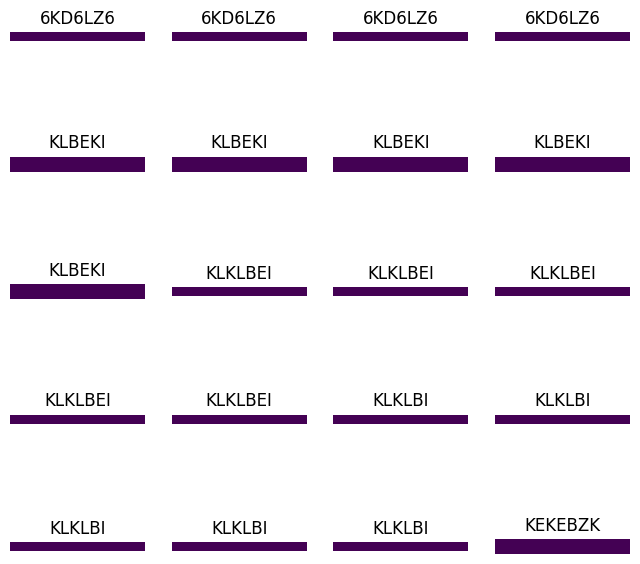

Character Accuracy: 11.06
Word Accuracy: 0.00
['6KD6LZ6', '6KD6LZ6', '6KD6LZ6', '6KD6LZ6', '6KD6LZ6', 'KLBEKI', 'KLBEKI', 'KLBEKI', 'KLBEKI', 'KLBEKI', 'KLKLBEI', 'KLKLBEI', 'KLKLBEI', 'KLKLBEI', 'KLKLBEI', 'KLKLBI', 'KLKLBI', 'KLKLBI', 'KLKLBI', 'KLKLBI', 'KEKEBZK', 'KEKEBZK', 'KEKEBZK', 'KEKEBZK', 'KEKEBZK', 'KEKEBZ', 'KEKEBZ', 'KEKEBZ', 'KEKEBZ', 'KEKEBZ', 'Q', 'K', 'L', 'Q', '6', 'L', 'E', 'Q']
['46Z8892MH', 'AK5600MH12', 'AP20N3100', 'DL10CG4693', 'DL49AK49', 'GJ05443', 'GJ7BB7666', 'H20CS1938', 'HR26BA8008', 'HR26BP3543', 'HR26DG6167', 'KA04ME9869', 'KL01BR8055', 'KL01CC50', 'KL07BF5000', 'KL09AL9540', 'KL10AV6342', 'KL43B2344', 'KL65E1000', 'MH02AJ344', 'MH02CB4545', 'MH15BD8877', 'MH15TC554', 'MH20CS1941', 'MK20TC189B', 'TN07BV5200', 'TN42R2697', 'TN43J0158', 'TN59AQ1515', 'TS09EB1458', 'WOBNP300']


In [71]:
args['imgdir'] = 'test'
args['data'] = SynthDataset(args)
resume_file = os.path.join(args['save_dir'], args['name'], 'best.ckpt')
if os.path.isfile(resume_file):
    print('Loading model %s'%resume_file)
    #checkpoint = torch.load(resume_file)
    #model.load_state_dict(checkpoint['state_dict'], strict=False)
    args['model'] = model
    ca, wa,pred,labels = get_accuracy(args)
    print("Character Accuracy: %.2f\nWord Accuracy: %.2f"%(ca, wa))
    print(pred)
    print(labels)
else:
    print("=> no checkpoint found at '{}'".format(save_file))
    print('Exiting')

In [72]:
print(torch.version)

<module 'torch.version' from 'c:\\Python311\\Lib\\site-packages\\torch\\version.py'>


## Part 4 and 5


The model's performance has been challenging, but I think it is expected due to the size of our dataset. So, as expected, the accuracy is relatively low due to the limited amount of training data. Although the accuracy has changed with each run, it hasn't exceeded 11%. Initially, the model struggled to make any predictions, with accuracy being either 0 or less than 1%. After implementing some changes, such as increasing the number of hidden layers and adjusting the batch size, I was able to achieve 1-5% accuracy. Moving forward, when I increased the number of epochs, the learning rate, and changed max pooling to average pooling, I managed to boost the accuracy to 11%. Even though I had expected a low accuracy, it the performance was poor, but I couldn't make it better.

To improve the accuracy and enhance performance, we could try increasing the dataset size to make it at least 10 times bigger, so the model has enough information to be trained on. The quality of the dataset could also be improved since some of the pictures are challenging even for human eyes. One of the possible mistakes might be related to character recognition, so I believe we could also try pre-trained models to minimize it.